In [1]:
import io
import numpy as np
import PIL
import requests
import torch
import openpifpaf
import os
import cv2
import matplotlib.pyplot as plt
import IPython
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#scikit-learn: Machine Learning in Python, Simple and efficient tools for data mining and data analysis
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.datasets import load_iris

#from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from scipy import ndimage, misc
import matplotlib.pyplot as plt

from PIL import Image
openpifpaf.show.Canvas.show = True
openpifpaf.show.Canvas.image_min_dpi = 200
os.environ['KMP_DUPLICATE_LIB_OK']='True'
print('OpenPifPaf version', openpifpaf.__version__)
print('PyTorch version', torch.__version__)

from tensorflow.math import reduce_prod

OpenPifPaf version 0.12.10
PyTorch version 1.8.1


In [2]:
def listdir_nohidden(path):
    ans = []
    for f in os.listdir(path):
        if not f.startswith('.'):
            ans.append(f)
    return ans

In [4]:
%%bash
python -m openpifpaf.predict dataTest/4.jpg --checkpoint=shufflenetv2k30-wholebody --line-width=2 --decoder=cifcaf:0 --show-file-extension=jpeg --image-output --json-output \
    

INFO:__main__:neural network device: cpu (CUDA available: False, count: 0)
INFO:openpifpaf.predictor:neural network device: cpu (CUDA available: False, count: 0)
[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.
INFO:openpifpaf.decoder.cifcaf:1 annotations: [74]
INFO:openpifpaf.predictor:batch 0: dataTest/4.jpg


In [3]:
def display(img):
    plt.imshow(img)
    plt.show()

## Face Detections ( Open CV )

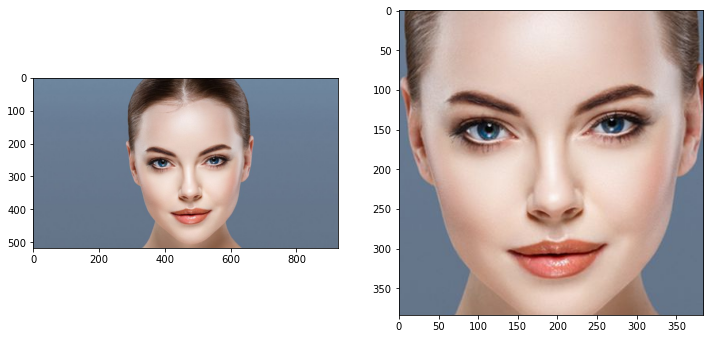

In [4]:
data = '2'
img = cv2.imread('dataTest/'+data+'.jpg')

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
crop_img = []
for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    crop_img.append(img[y:y+h, x:x+w])

if len(crop_img)==0 :
    crop_img.append(img)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(crop_img[0], cv2.COLOR_BGR2RGB))

In [249]:
for i in range(len(crop_img)):
    cv2.imwrite('dataTest/'+data+"crop"+str(i)+".jpg", crop_img[i])

## Apply OpenPifPaf on Crop Image

In [261]:
%%bash
python -m openpifpaf.predict dataTest/1.jpg --checkpoint=shufflenetv2k30-wholebody --line-width=2 --decoder=cifcaf:0 --show-file-extension=jpeg --image-output --json-output \

INFO:__main__:neural network device: cpu (CUDA available: False, count: 0)
INFO:openpifpaf.predictor:neural network device: cpu (CUDA available: False, count: 0)
[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.
INFO:openpifpaf.decoder.cifcaf:2 annotations: [130, 112]
INFO:openpifpaf.predictor:batch 0: dataTest/1.jpg


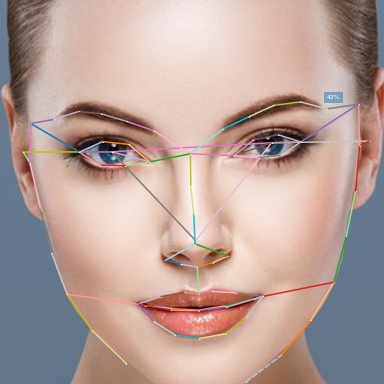

In [253]:
IPython.display.Image('dataTest/2crop0.jpg.predictions.jpeg')


In [252]:
with open('dataTest/5.jpg.predictions.json') as f:
  data = json.load(f)

## Extract Face Keypoint ( 24 - 91)

In [4]:
faceKey = data[0]['keypoints'][70:274]
faceKey = [faceKey[i * 3:(i + 1) * 3] for i in range((len(faceKey) + 2) // 3 )] 

TypeError: 'module' object is not subscriptable

In [30]:
faceKey = np.array(faceKey)

In [31]:
faceKey.shape

(68, 3)

## FER2013 dataset ( https://www.kaggle.com/msambare/fer2013 )

In [255]:
train_dir = 'FER2013/train/'
test_dir = 'FER2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        if (expression.startswith('.')):
            continue
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       happy   sad  fear  surprise  neutral  angry  disgust
train   7215  4830  4097      3171     4965   3995      436
      happy   sad  fear  surprise  neutral  angry  disgust
test   1774  1247  1024       831     1233    958      111


<AxesSubplot:>

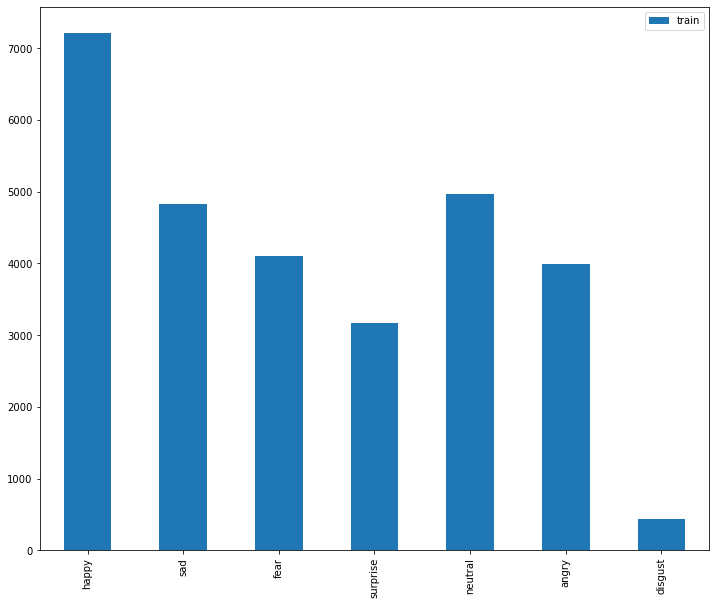

In [237]:
train_count.transpose().plot(kind='bar', figsize=(12,10))

In [3]:
data = '5'
pil_im = cv2.imread('dataTest/'+data+'.jpg',0)
image = cv2.cvtColor(pil_im, cv2.COLOR_BGR2RGB)

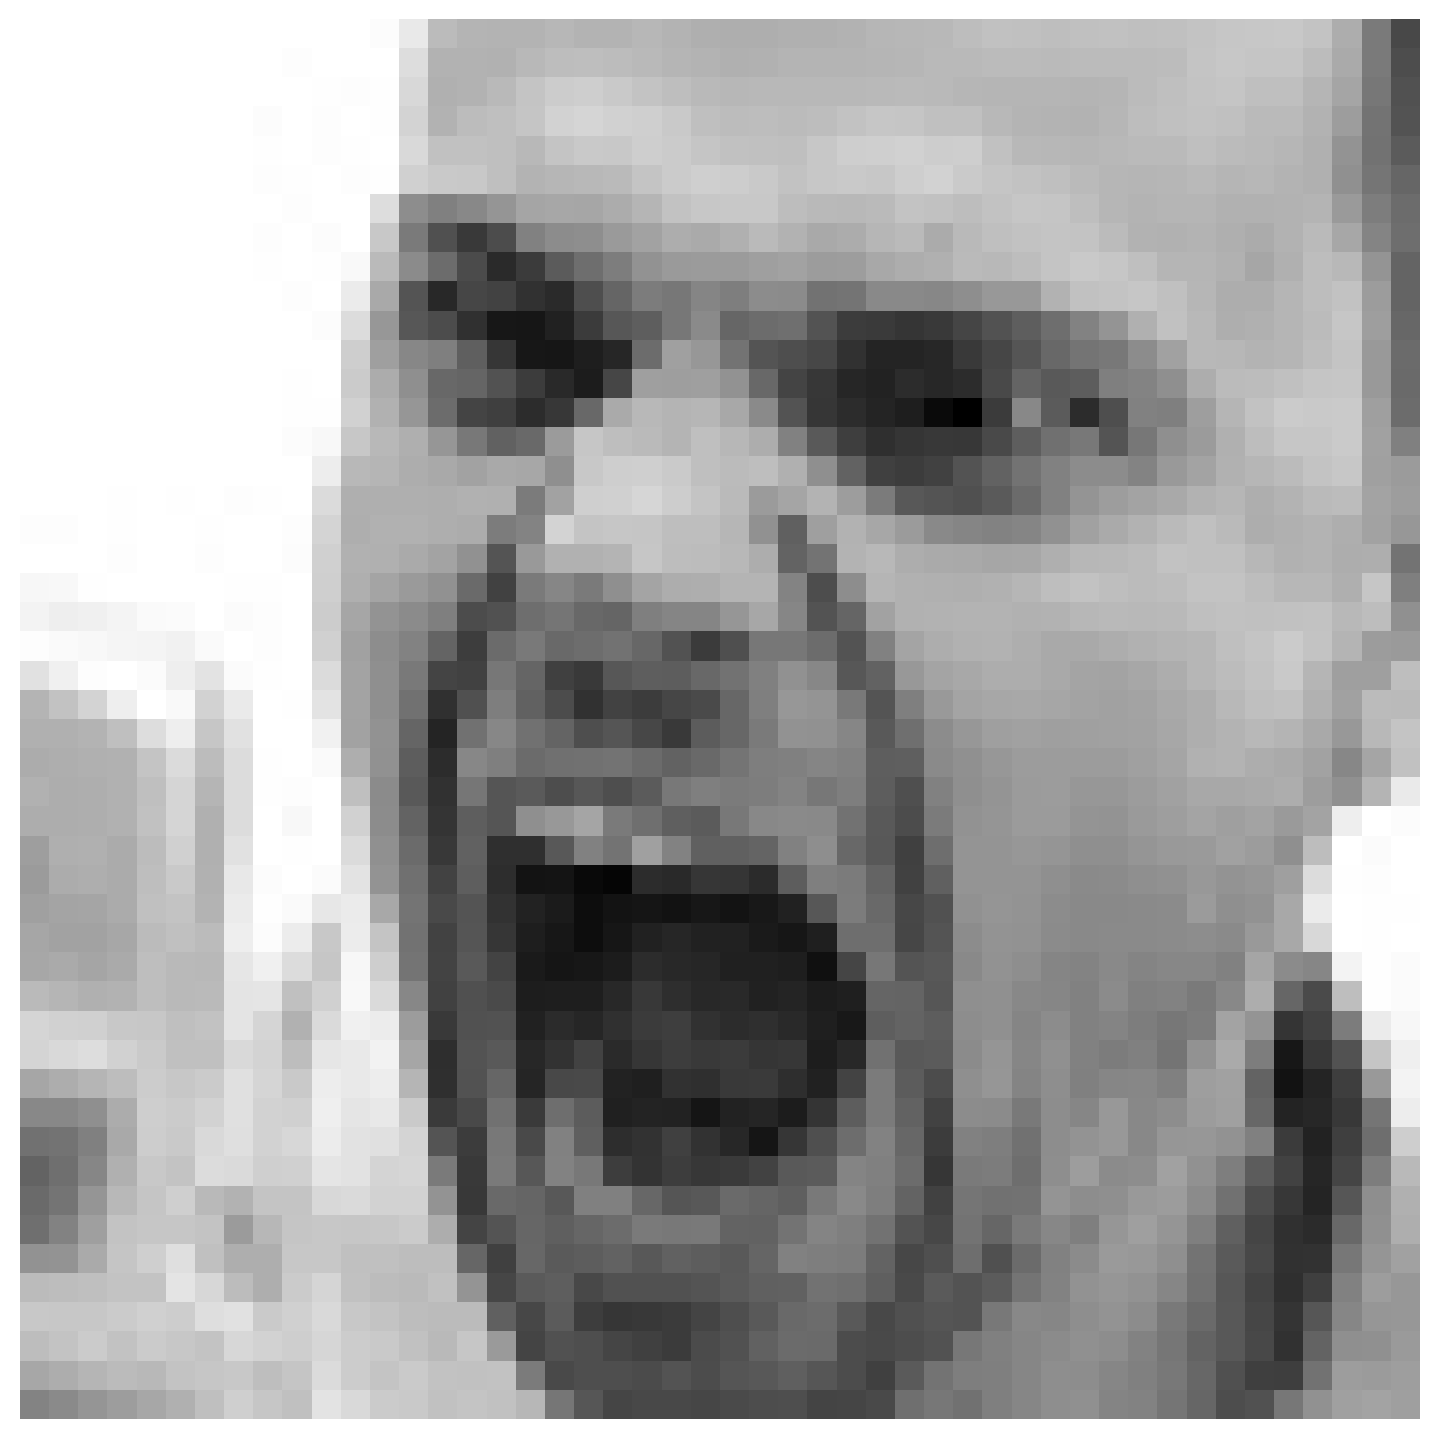

In [4]:
with openpifpaf.show.Canvas.image(image) as ax:
    pass

In [5]:
predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16-wholebody')
predictions, gt_anns, meta = predictor.numpy_image(image)

In [6]:
print(predictions)

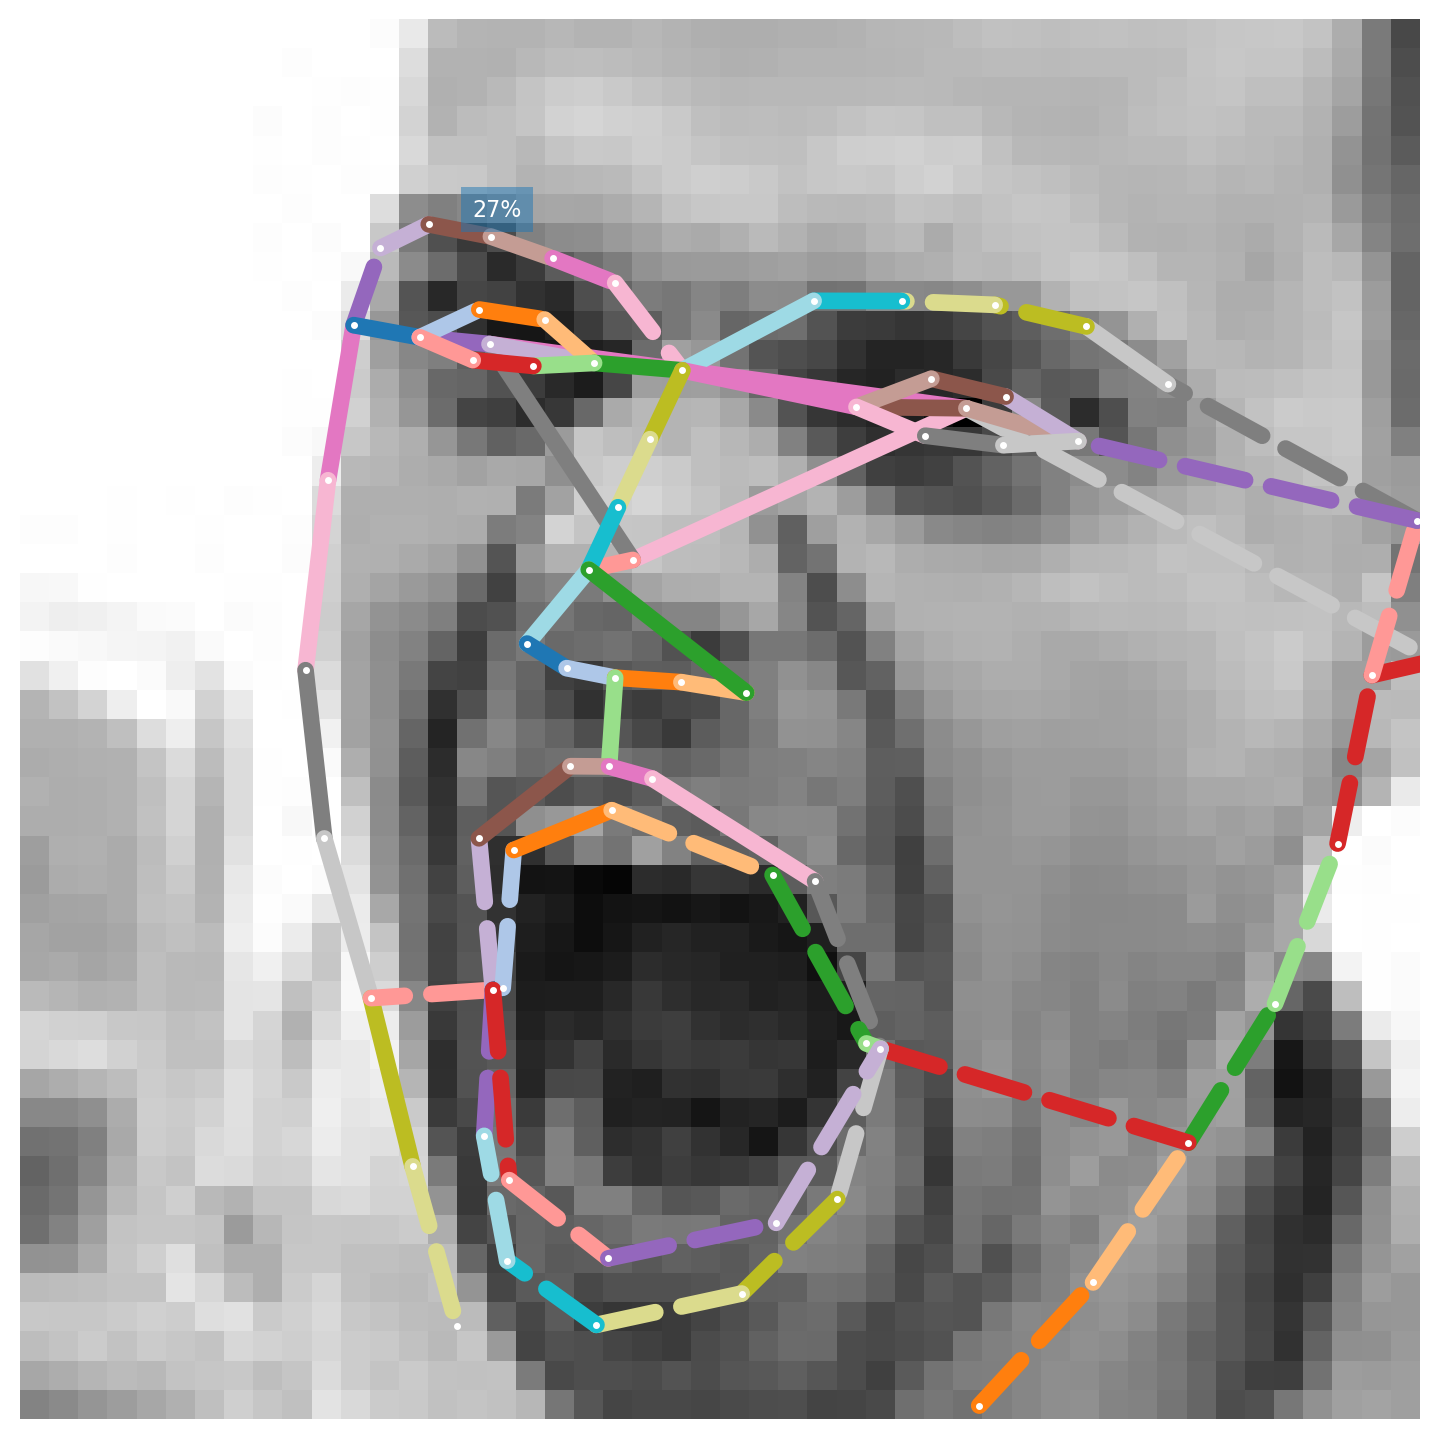

In [241]:
annotation_painter = openpifpaf.show.AnnotationPainter()
with openpifpaf.show.Canvas.image(image) as ax:
    annotation_painter.annotations(ax, predictions)

In [65]:
model_input = [predictions[0].data,'Sad']

In [66]:
model_input[0]

array([[20.509964  , 18.046368  ,  0.6425539 ],
       [31.947437  , 12.846975  ,  0.7532809 ],
       [15.597678  , 10.644807  ,  0.63797367],
       [47.997116  , 21.50155   ,  0.4205362 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

## 

## OpenPifPaf API Function

In [162]:
def openpifpafFaceKey(img,emotion ='None'):
    predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16-wholebody')
    predictions, gt_anns, meta = predictor.numpy_image(img)
    if len(predictions) == 0 :
        emotion = 'ERROR'
        faceKey = []
        for i in range(68):
            faceKey.append([0,0,0])
    else :
        faceKey = predictions[0].data[24:92]

    return faceKey,emotion

## Crop True = Apply CV2 face detection
## Scale True = Apply MinMax Scaling
def openpifpafFaceKeyRead(path,Scale,Crop=False,Show=False):
    img = cv2.imread(path)

    if Crop :
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        crop_img = []
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            crop_img.append(img[y:y+h, x:x+w])

        if len(crop_img)==0 :
            crop_img.append(img)

    emotion = path.split('/')[2]
    
    predictor = openpifpaf.Predictor(checkpoint='shufflenetv2k16-wholebody')
    predictions, gt_anns, meta = predictor.numpy_image(img)
    if len(predictions) == 0 :
        emotion = 'ERROR'
        Show = False
        Scale = False
        faceKey = []
        for i in range(68):
            faceKey.append([0,0,0])
    else :
        faceKey = predictions[0].data[24:92]
            
    if Show :
        annotation_painter = openpifpaf.show.AnnotationPainter()
        with openpifpaf.show.Canvas.image(img) as ax:
            annotation_painter.annotations(ax, predictions)
    if Scale :
        scaler = MinMaxScaler()
        faceKey[:,0:2] = scaler.fit_transform(faceKey[:,0:2])

    return faceKey,emotion

In [183]:
faceTest = openpifpafFaceKey(img)
faceTest

array([[10.060131  , 15.314257  ,  0.51949555],
       [ 9.289757  , 21.827284  ,  0.5154759 ],
       [ 9.933698  , 27.594965  ,  0.51558477],
       [11.53378   , 33.069984  ,  0.52087307],
       [12.960931  , 38.839146  ,  0.50306225],
       [14.489385  , 44.31837   ,  0.43337113],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [32.38743   , 47.039013  ,  0.37323257],
       [36.290688  , 42.81767   ,  0.42203766],
       [39.555344  , 38.024563  ,  0.47308636],
       [42.52922   , 33.262226  ,  0.43546605],
       [44.674213  , 27.770868  ,  0.40354472],
       [45.851     , 21.995743  ,  0.4064267 ],
       [47.40033   , 16.696772  ,  0.46306628],
       [11.859463  ,  7.351821  ,  0.42183444],
       [13.514491  ,  6.5402913 ,  0.40683952],
       [15.645255  ,  6.9585433 ,  0.42741132],
       [17.761427  ,  7.703288  ,  0.43911174],
       [19.907026  ,  8.547639  ,  0.481

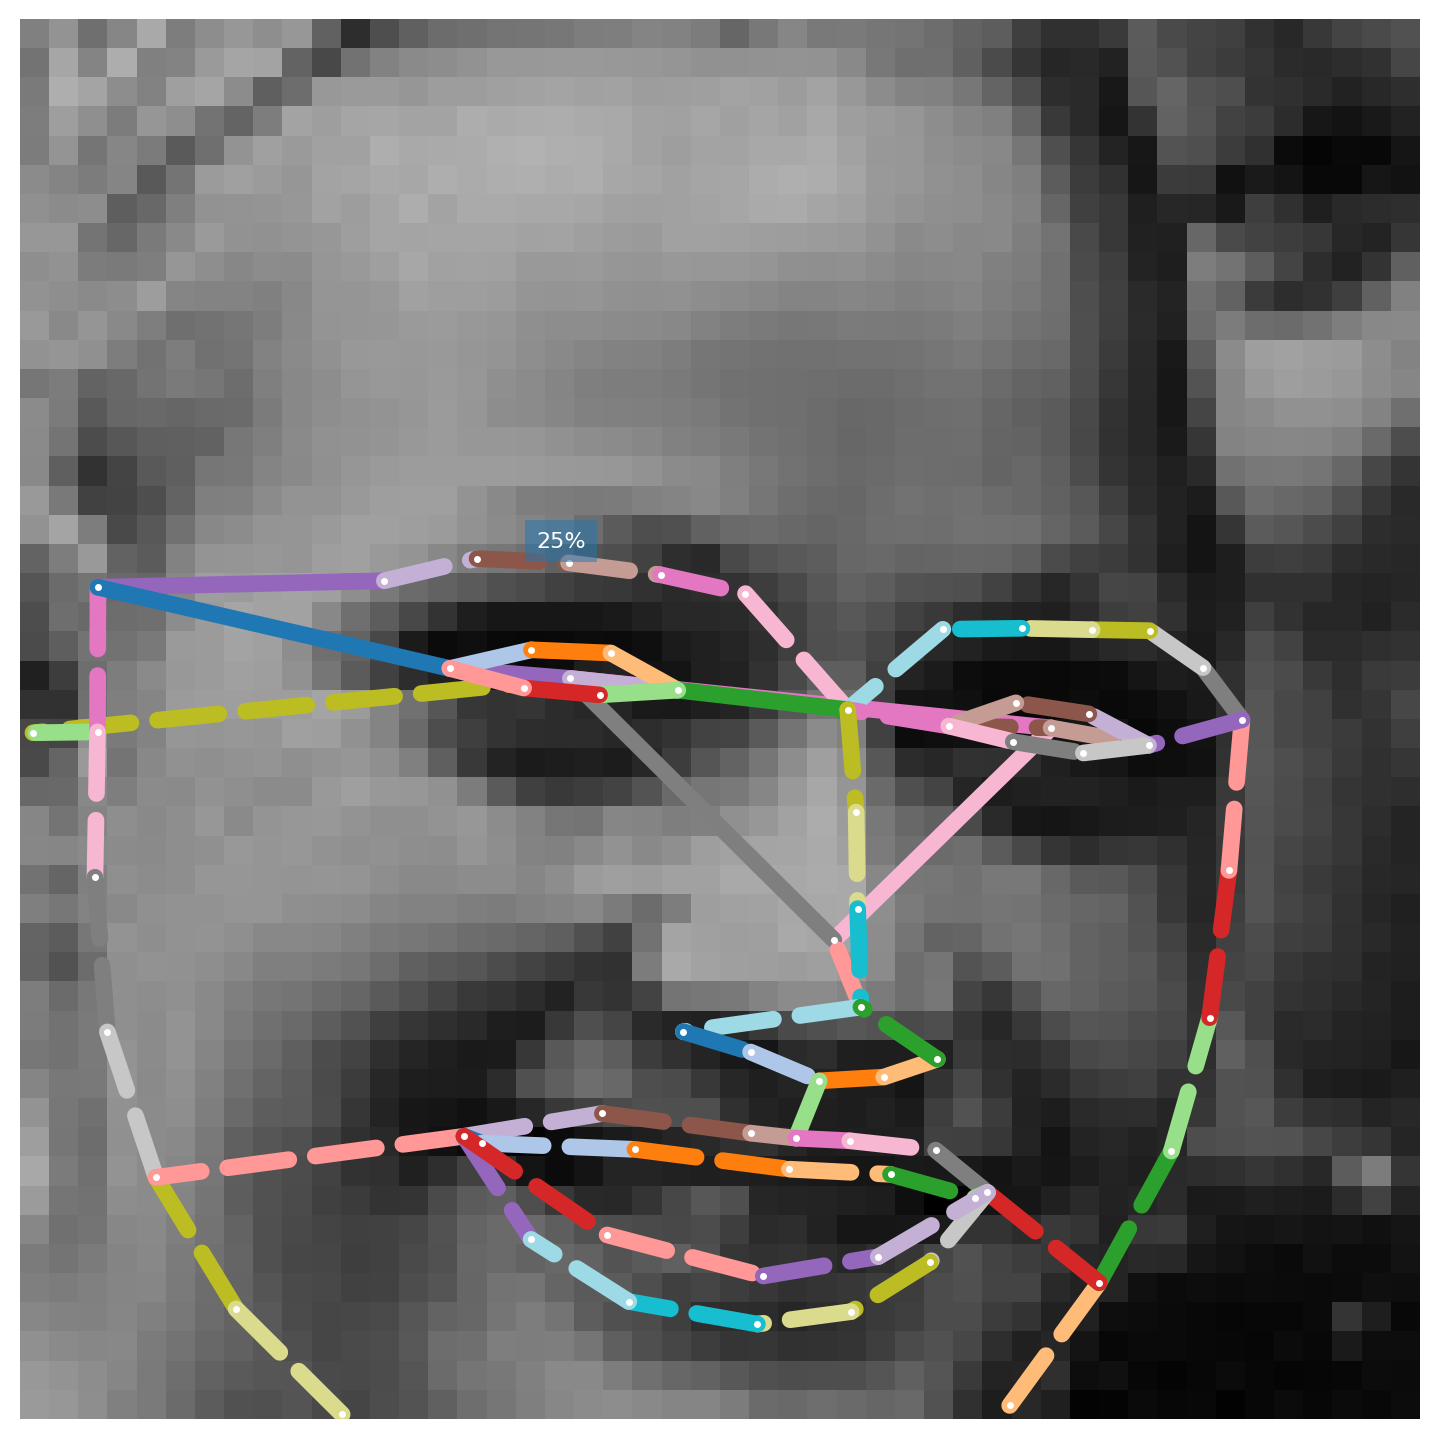

(array([[0.05211464, 0.5057114 , 0.48377877],
        [0.05000854, 0.61099195, 0.45667046],
        [0.06028727, 0.7230026 , 0.4459943 ],
        [0.1005715 , 0.8283604 , 0.43049315],
        [0.1669023 , 0.9235976 , 0.40403202],
        [0.25474256, 1.        , 0.360249  ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.80759794, 0.99354833, 0.36892474],
        [0.88172907, 0.9046453 , 0.39624897],
        [0.9414973 , 0.809297  , 0.41515994],
        [0.9731404 , 0.7127107 , 0.41111588],
        [0.9891906 , 0.6060725 , 0.41292125],
        [1.        , 0.4968649 , 0.42911747],
        [0.28967875, 0.3962799 , 0.52413625],
        [0.3664569 , 0.38021463, 0.49589324],
        [0.44221303, 0.38327986, 0.48852327],
        [0.51850194, 0.39196154, 0.4551417 ],
        [0.58879757, 0.4055847 , 0.42167148],
        [0.75225806, 0.43142596, 0

In [189]:
openpifpafFaceKeyRead('FER2013/train/happy/Training_68121933.jpg',Crop = False,Scale = True,Show=True)

## Get train data

In [251]:
allPath = []
for expression in listdir_nohidden("FER2013/train/"):
    directory = "FER2013/train/" + expression
    for pic in listdir_nohidden(directory):
        allPath.append(directory+'/'+pic)

## Get test data

In [293]:
allPathTest = []
for expression in listdir_nohidden("FER2013/test/"):
    directory = "FER2013/test/" + expression
    for pic in listdir_nohidden(directory):
        allPathTest.append(directory+'/'+pic)

## Create CSV

In [295]:
ans = openpifpafFaceKeyRead(allPathTest[0],Crop = False,Scale = False,Show=False)

In [298]:
dict = {'Name': [allPathTest[0].split('/')[2] + '/' + allPathTest[0].split('/')[3]],
        'Emotion': [ans[1]],
        'Landmark24': [ans[0][0]],
        'Landmark25': [ans[0][1]],
        'Landmark26': [ans[0][2]],
        'Landmark27': [ans[0][3]],
        'Landmark28': [ans[0][4]],
        'Landmark29': [ans[0][5]],
        'Landmark30': [ans[0][6]],
        'Landmark31': [ans[0][7]],
        'Landmark32': [ans[0][8]],
        'Landmark33': [ans[0][9]],
        'Landmark34': [ans[0][10]],
        'Landmark35': [ans[0][11]],
        'Landmark36': [ans[0][12]],
        'Landmark37': [ans[0][13]],
        'Landmark38': [ans[0][14]],
        'Landmark39': [ans[0][15]],
        'Landmark40': [ans[0][16]],
        'Landmark41': [ans[0][17]],
        'Landmark42': [ans[0][18]],
        'Landmark43': [ans[0][19]],
        'Landmark44': [ans[0][20]],
        'Landmark45': [ans[0][21]],    
        'Landmark46': [ans[0][22]],
        'Landmark47': [ans[0][23]],
        'Landmark48': [ans[0][24]],
        'Landmark49': [ans[0][25]],                 
        'Landmark50': [ans[0][26]],                 
        'Landmark51': [ans[0][27]],                  
        'Landmark52': [ans[0][28]],                  
        'Landmark53': [ans[0][29]],                  
        'Landmark54': [ans[0][30]],                  
        'Landmark55': [ans[0][31]],                  
        'Landmark56': [ans[0][32]],                                 
        'Landmark57': [ans[0][33]],  
        'Landmark58': [ans[0][34]],                 
        'Landmark59': [ans[0][35]],                 
        'Landmark60': [ans[0][36]],                 
        'Landmark61': [ans[0][37]],                 
        'Landmark62': [ans[0][38]],                
        'Landmark63': [ans[0][39]],                
        'Landmark64': [ans[0][40]],                
        'Landmark65': [ans[0][41]],                
        'Landmark66': [ans[0][42]],                
        'Landmark67': [ans[0][43]],                
        'Landmark68': [ans[0][44]],                
        'Landmark69': [ans[0][45]],                
        'Landmark70': [ans[0][46]],                
        'Landmark71': [ans[0][47]],                
        'Landmark72': [ans[0][48]],                
        'Landmark73': [ans[0][49]],                
        'Landmark74': [ans[0][50]],                
        'Landmark75': [ans[0][51]],                
        'Landmark76': [ans[0][52]],                
        'Landmark77': [ans[0][53]],                
        'Landmark78': [ans[0][54]],                
        'Landmark79': [ans[0][55]],                
        'Landmark80': [ans[0][56]],                
        'Landmark81': [ans[0][57]],                
        'Landmark82': [ans[0][58]],                
        'Landmark83': [ans[0][59]],                
        'Landmark84': [ans[0][60]],                
        'Landmark85': [ans[0][61]],                
        'Landmark86': [ans[0][62]],                
        'Landmark87': [ans[0][63]],                
        'Landmark88': [ans[0][64]],                
        'Landmark89': [ans[0][65]],                
        'Landmark90': [ans[0][66]],                
        'Landmark91': [ans[0][67]]}

In [301]:
df = pd.DataFrame(dict)
df

,Name,Emotion,Landmark24,Landmark25,Landmark26,Landmark27,Landmark28,Landmark29,Landmark30,Landmark31,...,Landmark82,Landmark83,Landmark84,Landmark85,Landmark86,Landmark87,Landmark88,Landmark89,Landmark90,Landmark91
0,happy/PrivateTest_45699463.jpg,happy,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.4389545, 36.922672, 0.53944683]","[3.4045525, 41.859818, 0.47155327]","[6.8806443, 46.204613, 0.43630388]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[12.770836, 40.79355, 0.576201]","[11.6121, 36.73345, 0.59607923]","[16.987535, 36.90546, 0.62831545]","[22.77759, 38.060364, 0.61997163]","[26.628277, 38.38908, 0.58390075]","[30.131319, 39.267727, 0.57162833]","[26.305777, 43.108833, 0.52180123]","[21.356739, 43.86731, 0.47003904]","[15.642509, 41.77792, 0.5364929]","[0.0, 0.0, 0.0]"


In [303]:
allPathDf = allPathTest[1:]

for i in allPathDf :
    ans = openpifpafFaceKeyRead(i,Crop = False,Scale = False,Show=False)
    dictDf = {'Name': [i.split('/')[2] + '/' + i.split('/')[3]],
        'Emotion': [ans[1]],
        'Landmark24': [ans[0][0]],
        'Landmark25': [ans[0][1]],
        'Landmark26': [ans[0][2]],
        'Landmark27': [ans[0][3]],
        'Landmark28': [ans[0][4]],
        'Landmark29': [ans[0][5]],
        'Landmark30': [ans[0][6]],
        'Landmark31': [ans[0][7]],
        'Landmark32': [ans[0][8]],
        'Landmark33': [ans[0][9]],
        'Landmark34': [ans[0][10]],
        'Landmark35': [ans[0][11]],
        'Landmark36': [ans[0][12]],
        'Landmark37': [ans[0][13]],
        'Landmark38': [ans[0][14]],
        'Landmark39': [ans[0][15]],
        'Landmark40': [ans[0][16]],
        'Landmark41': [ans[0][17]],
        'Landmark42': [ans[0][18]],
        'Landmark43': [ans[0][19]],
        'Landmark44': [ans[0][20]],
        'Landmark45': [ans[0][21]],    
        'Landmark46': [ans[0][22]],
        'Landmark47': [ans[0][23]],
        'Landmark48': [ans[0][24]],
        'Landmark49': [ans[0][25]],                 
        'Landmark50': [ans[0][26]],                 
        'Landmark51': [ans[0][27]],                  
        'Landmark52': [ans[0][28]],                  
        'Landmark53': [ans[0][29]],                  
        'Landmark54': [ans[0][30]],                  
        'Landmark55': [ans[0][31]],                  
        'Landmark56': [ans[0][32]],                                 
        'Landmark57': [ans[0][33]],  
        'Landmark58': [ans[0][34]],                 
        'Landmark59': [ans[0][35]],                 
        'Landmark60': [ans[0][36]],                 
        'Landmark61': [ans[0][37]],                 
        'Landmark62': [ans[0][38]],                
        'Landmark63': [ans[0][39]],                
        'Landmark64': [ans[0][40]],                
        'Landmark65': [ans[0][41]],                
        'Landmark66': [ans[0][42]],                
        'Landmark67': [ans[0][43]],                
        'Landmark68': [ans[0][44]],                
        'Landmark69': [ans[0][45]],                
        'Landmark70': [ans[0][46]],                
        'Landmark71': [ans[0][47]],                
        'Landmark72': [ans[0][48]],                
        'Landmark73': [ans[0][49]],                
        'Landmark74': [ans[0][50]],                
        'Landmark75': [ans[0][51]],                
        'Landmark76': [ans[0][52]],                
        'Landmark77': [ans[0][53]],                
        'Landmark78': [ans[0][54]],                
        'Landmark79': [ans[0][55]],                
        'Landmark80': [ans[0][56]],                
        'Landmark81': [ans[0][57]],                
        'Landmark82': [ans[0][58]],                
        'Landmark83': [ans[0][59]],                
        'Landmark84': [ans[0][60]],                
        'Landmark85': [ans[0][61]],                
        'Landmark86': [ans[0][62]],                
        'Landmark87': [ans[0][63]],                
        'Landmark88': [ans[0][64]],                
        'Landmark89': [ans[0][65]],                
        'Landmark90': [ans[0][66]],                
        'Landmark91': [ans[0][67]]}
    dfLoop = pd.DataFrame(dictDf)
    df = df.append(dfLoop)

df.to_csv('landMarkTest.csv',index=False)

In [335]:
df

,Name,Emotion,Landmark24,Landmark25,Landmark26,Landmark27,Landmark28,Landmark29,Landmark30,Landmark31,...,Landmark82,Landmark83,Landmark84,Landmark85,Landmark86,Landmark87,Landmark88,Landmark89,Landmark90,Landmark91
0,happy/PrivateTest_45699463.jpg,happy,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.4389545, 36.922672, 0.53944683]","[3.4045525, 41.859818, 0.47155327]","[6.8806443, 46.204613, 0.43630388]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[12.770836, 40.79355, 0.576201]","[11.6121, 36.73345, 0.59607923]","[16.987535, 36.90546, 0.62831545]","[22.77759, 38.060364, 0.61997163]","[26.628277, 38.38908, 0.58390075]","[30.131319, 39.267727, 0.57162833]","[26.305777, 43.108833, 0.52180123]","[21.356739, 43.86731, 0.47003904]","[15.642509, 41.77792, 0.5364929]","[0.0, 0.0, 0.0]"
0,happy/PrivateTest_61855708.jpg,happy,"[13.4294815, 26.869932, 0.524748]","[14.713011, 30.833553, 0.52980745]","[17.1081, 33.970535, 0.5101629]","[19.223606, 37.201298, 0.4785787]","[22.192482, 39.536457, 0.44209012]","[25.759924, 41.42024, 0.43370906]","[29.473991, 41.492252, 0.39161962]","[32.83839, 40.057213, 0.35904917]",...,"[24.248325, 35.156235, 0.44224998]","[23.11813, 33.49437, 0.4352564]","[23.442379, 31.234335, 0.40686464]","[24.83446, 29.697401, 0.39445278]","[27.646666, 28.95115, 0.4017937]","[30.63779, 29.632442, 0.38931346]","[29.20962, 32.06434, 0.35394138]","[27.191397, 34.11994, 0.3910647]","[25.065084, 34.248188, 0.42901707]","[0.0, 0.0, 0.0]"
0,happy/PublicTest_53681781.jpg,happy,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[14.658435, 41.98733, 0.45973015]","[11.989038, 38.400414, 0.55296266]","[19.198511, 37.37287, 0.5694826]","[26.677721, 37.16098, 0.5780489]","[29.167414, 37.448826, 0.56822485]","[30.946613, 37.834213, 0.54571784]","[28.759447, 40.998802, 0.50963867]","[25.241016, 42.457096, 0.4876598]","[17.915768, 41.915123, 0.4901771]","[0.0, 0.0, 0.0]"
0,happy/PrivateTest_52109800.jpg,happy,"[1.5649071, 26.341328, 0.5170179]","[1.5864245, 31.533436, 0.5125946]","[3.0595484, 37.116844, 0.51534396]","[5.8668985, 42.047035, 0.50733584]","[8.788584, 46.817894, 0.4664863]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[13.964142, 42.34465, 0.4726049]","[13.670921, 37.146114, 0.6103774]","[16.314468, 32.175747, 0.6088773]","[21.311434, 30.375233, 0.60841715]","[26.403624, 32.124237, 0.5876143]","[29.515646, 37.28986, 0.5717684]","[26.42583, 43.77673, 0.3402973]","[20.566238, 45.784077, 0.3631446]","[15.617373, 43.476536, 0.46053597]","[0.0, 0.0, 0.0]"
0,happy/PublicTest_41104919.jpg,happy,"[1.7840654, 23.316378, 0.56660557]","[3.2234344, 28.935827, 0.6033927]","[5.0955014, 34.31504, 0.65141076]","[7.791473, 39.311943, 0.6706154]","[11.8976965, 43.250633, 0.6301821]","[16.657701, 46.395714, 0.5723283]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[18.930643, 38.253807, 0.68864125]","[16.90296, 36.441517, 0.67350084]","[21.559114, 37.130974, 0.662565]","[26.05533, 37.271782, 0.69018465]","[30.222008, 36.10368, 0.69821024]","[34.225033, 34.429638, 0.6430471]","[30.42283, 36.317333, 0.6720528]","[26.139032, 37.39288, 0.6754442]","[21.299128, 37.34502, 0.67568874]","[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,disgust/PrivateTest_79683471.jpg,disgust,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[14.454208, 43.24472, 0.44586068]","[11.838116, 38.63108, 0.51054317]","[19.264126, 36.33224, 0.5316228]","[27.053675, 36.04365, 0.54139596]","[31.370466, 36.697758, 0.54282176]","[34.73458, 38.5709, 0.5063781]","[30.883192, 43.111702, 0.49528155]","[25.534744, 44.684315, 0.415063]","[17.881212, 43.390507, 0.44022325]","[0.0, 0.0, 0.0]"
0,disgust/PrivateTest_34013087.jpg,disgust,"[0.0, 0.0, 0.0]","[0.7672865, 29.982906, 0.50442284]","[3.3287942, 36.61424, 0.5282

In [305]:
df.to_json("landMarkFER2013_Test.json", orient = 'table')

# Simple Model

## Prepare Train and Test Data

In [12]:
dfTrain = pd.read_json("landMarkFER2013_Train.json",orient='table')
dfTrainOver = pd.read_json("landMarkFER2013_TrainOverSam.json",orient='table')

dfTrain = dfTrain.append(dfTrainOver)
dfTrain = dfTrain.drop('index',axis = 1)



In [14]:
dfTrain.head()

,Name,Emotion,Landmark24,Landmark25,Landmark26,Landmark27,Landmark28,Landmark29,Landmark30,Landmark31,...,Landmark82,Landmark83,Landmark84,Landmark85,Landmark86,Landmark87,Landmark88,Landmark89,Landmark90,Landmark91
0,happy/Training_50449107.jpg,happy,"[0.842373848, 24.1850624084, 0.5427526832]","[3.0311529636, 30.6417350769, 0.5752133727000001]","[5.9096198082, 36.6908569336, 0.5897347331]","[9.5904941559, 42.3283424377, 0.5862258077]","[14.3023347855, 46.9412460327, 0.5367392898000...","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[20.8943023682, 42.0661697388, 0.5740033984]","[18.529706955, 40.3176231384, 0.5802235603]","[23.6347103119, 40.5757522583, 0.577647686]","[28.3722267151, 40.3755111694, 0.6027099490000...","[33.2416992188, 38.6361732483, 0.6355236769]","[38.0357437134, 36.3610992432, 0.6189918518]","[33.6171340942, 38.8237495422, 0.6024183035]","[28.5800266266, 40.4688186646, 0.5766807199]","[23.5480995178, 40.7470588684, 0.5720650554]","[0.0, 0.0, 0.0]"
1,happy/Training_70433018.jpg,happy,"[1.88245368, 27.1108818054, 0.5492312312000001]","[3.5109658241, 32.6854896545, 0.5695711374]","[5.492266655, 38.2848014832, 0.5746636987]","[8.289147377, 43.3774108887, 0.5868979692]","[12.3787717819, 47.1906700134, 0.5388913155]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[20.7762889862, 40.9224433899, 0.5817713141]","[18.8597812653, 39.4695320129, 0.6360434294]","[22.6587295532, 38.92004776, 0.6227163672]","[26.5502853394, 38.2326812744, 0.6100099087]","[29.7685985565, 37.42603302, 0.6549973488]","[32.9736480713, 36.8846664429, 0.6910737157]","[29.9422187805, 38.0158920288, 0.6801444292000...","[26.7154560089, 38.9560432434, 0.6305826902]","[23.0909004211, 39.239112854, 0.6299825907000001]","[0.0, 0.0, 0.0]"
2,happy/Training_85610005.jpg,happy,"[2.9210407734, 21.8782596588, 0.6398373246]","[4.8748993874, 28.1255512238, 0.6935491562]","[7.6845970154, 33.7035446167, 0.7229239345]","[11.2599134445, 38.6997833252, 0.7151069641000...","[15.9263944626, 43.1260070801, 0.672748208]","[21.0471897125, 46.9376373291, 0.5907588601]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[21.1655254364, 39.8240432739, 0.6593232751]","[19.8576622009, 37.3516960144, 0.7070408463000...","[22.343132019, 36.454990387, 0.7166365981]","[25.2754039764, 35.9104652405, 0.718367219]","[29.8551044464, 34.9216117859, 0.7188365459]","[34.6249237061, 34.4071846008, 0.6433709860000...","[31.3640022278, 37.6418495178, 0.6637164354]","[26.6090888977, 39.2998580933, 0.6286574006]","[22.9871711731, 39.0905303955, 0.6948604584]","[0.0, 0.0, 0.0]"
3,happy/Training_4460748.jpg,happy,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.33755370970000004, 38.6912078857, 0.3082396...","[2.4013123512, 45.9893302917, 0.3208863437]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[14.7427186966, 45.1363334656, 0.3826481402]","[12.1192169189, 42.7144966125, 0.3529213965000...","[17.9721374512, 42.910118103, 0.3618418276]","[24.0240478516, 43.4547653198, 0.3644569516]","[30.1340141296, 42.9585266113, 0.3634091318]","[36.1434593201, 42.3001480103, 0.3367975652000...","[30.4266490936, 44.062297821, 0.3703675568]","[24.0604496002, 44.8569412231, 0.3902082145000...","[17.6914463043, 44.3107185364, 0.4084504843]","[0.0, 0.0, 0.0]"
4,happy/Training_6312930.jpg,happy,"[1.7136244774, 17.1662979126, 0.4704746902]","[2.079190731, 23.0171508789, 0.4841368794]","[3.0986044407, 28.743976593, 0.5036540627]","[4.981148243, 34.222026825, 0.5482786298]","[7.8752002716, 39.3434524536, 0.5379731059]","[11.7376823425, 43.808883667, 0.49919328090000...","[16.0823612213, 47.4988098145, 0.4465089738000...","[0.0, 0.0, 0.0]",...,"[13.8290805817, 34.1574707031, 0.6029655933]","[12.4233236313, 29.4261989594, 0.5415914655]","[17.0135650635, 27.4720344543, 0.6055155993]","[22.316696167, 27.3284854889, 0.6060394049]","[27.4860725403, 27.7577018738, 0.5730203986]","[31.8599643707, 30.0425205231, 0.5722458959]","[27.7173862457, 35.4725532532, 0.5456646085]","[21.95744

In [15]:
dfTrain.shape

(31325, 70)

In [16]:
for i in range(24,92):
    dfTrain['Landmark_{}_x'.format(i)] = dfTrain.loc[:,'Landmark{}'.format(i)].apply(lambda x: x[0])    
    dfTrain['Landmark_{}_y'.format(i)] = dfTrain.loc[:,'Landmark{}'.format(i)].apply(lambda x: x[1])
    dfTrain['Landmark_{}_conf'.format(i)] = dfTrain.loc[:,'Landmark{}'.format(i)].apply(lambda x: x[2])
    dfTrain = dfTrain.drop('Landmark{}'.format(i),axis=1)

In [17]:
dfTrain.head()

,Name,Emotion,Landmark_24_x,Landmark_24_y,Landmark_24_conf,Landmark_25_x,Landmark_25_y,Landmark_25_conf,Landmark_26_x,Landmark_26_y,...,Landmark_88_conf,Landmark_89_x,Landmark_89_y,Landmark_89_conf,Landmark_90_x,Landmark_90_y,Landmark_90_conf,Landmark_91_x,Landmark_91_y,Landmark_91_conf
0,happy/Training_50449107.jpg,happy,0.842374,24.185062,0.542753,3.031153,30.641735,0.575213,5.909620,36.690857,...,0.602418,28.580027,40.468819,0.576681,23.548100,40.747059,0.572065,0.0,0.0,0.0
1,happy/Training_70433018.jpg,happy,1.882454,27.110882,0.549231,3.510966,32.685490,0.569571,5.492267,38.284801,...,0.680144,26.715456,38.956043,0.630583,23.090900,39.239113,0.629983,0.0,0.0,0.0
2,happy/Training_85610005.jpg,happy,2.921041,21.878260,0.639837,4.874899,28.125551,0.693549,7.684597,33.703545,...,0.663716,26.609089,39.299858,0.628657,22.987171,39.090530,0.694860,0.0,0.0,0.0
3,happy/Training_4460748.jpg,happy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337554,38.691208,...,0.370368,24.060450,44.856941,0.390208,17.691446,44.310719,0.408450,0.0,0.0,0.0
4,happy/Training_6312930.jpg,happy,1.713624,17.166298,0.470475,2.079191,23.017151,0.484137,3.098604,28.743977,...,0.545665,21.957443,37.128841,0.583965,16.257973,35.074383,0.604799,0.0,0.0,0.0


In [18]:
# Drop ERROR data
dfTrain = dfTrain[dfTrain['Emotion'] != 'ERROR']

In [19]:
dfTest = pd.read_json("landMarkFER2013_Test.json",orient='table')
dfTest = dfTest.drop('index',axis = 1)

for i in range(24,92):
    dfTest['Landmark_{}_x'.format(i)] = dfTest.loc[:,'Landmark{}'.format(i)].apply(lambda x: x[0])    
    dfTest['Landmark_{}_y'.format(i)] = dfTest.loc[:,'Landmark{}'.format(i)].apply(lambda x: x[1])
    dfTest['Landmark_{}_conf'.format(i)] = dfTest.loc[:,'Landmark{}'.format(i)].apply(lambda x: x[2])
    dfTest = dfTest.drop('Landmark{}'.format(i),axis=1)

dfTest = dfTest[dfTest['Emotion'] != 'ERROR']

In [20]:
dfTest

,Name,Emotion,Landmark_24_x,Landmark_24_y,Landmark_24_conf,Landmark_25_x,Landmark_25_y,Landmark_25_conf,Landmark_26_x,Landmark_26_y,...,Landmark_88_conf,Landmark_89_x,Landmark_89_y,Landmark_89_conf,Landmark_90_x,Landmark_90_y,Landmark_90_conf,Landmark_91_x,Landmark_91_y,Landmark_91_conf
0,happy/PrivateTest_45699463.jpg,happy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.521801,21.356739,43.867310,0.470039,15.642509,41.777920,0.536493,0.0,0.0,0.0
1,happy/PrivateTest_61855708.jpg,happy,13.429482,26.869932,0.524748,14.713011,30.833553,0.529807,17.108101,33.970535,...,0.353941,27.191397,34.119942,0.391065,25.065084,34.248188,0.429017,0.0,0.0,0.0
2,happy/PublicTest_53681781.jpg,happy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.509639,25.241016,42.457096,0.487660,17.915768,41.915123,0.490177,0.0,0.0,0.0
3,happy/PrivateTest_52109800.jpg,happy,1.564907,26.341328,0.517018,1.586424,31.533436,0.512595,3.059548,37.116844,...,0.340297,20.566238,45.784077,0.363145,15.617373,43.476536,0.460536,0.0,0.0,0.0
4,happy/PublicTest_41104919.jpg,happy,1.784065,23.316378,0.566606,3.223434,28.935827,0.603393,5.095501,34.315041,...,0.672053,26.139032,37.392879,0.675444,21.299128,37.345020,0.675689,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7173,disgust/PrivateTest_79683471.jpg,disgust,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.495282,25.534744,44.684315,0.415063,17.881212,43.390507,0.440223,0.0,0.0,0.0
7174,disgust/PrivateTest_34013087.jpg,disgust,0.000000,0.000000,0.000000,0.767286,29.982906,0.504423,3.328794,36.614239,...,0.609528,26.949949,39.360603,0.561152,21.865664,39.333187,0.523873,0.0,0.0,0.0
7175,disgust/PublicTest_67559665.jpg,disgust,3.805317,24.062920,0.596615,5.075456,29.504126,0.611114,6.552660,34.932434,...,0.653887,25.812580,37.784386,0.644039,22.296568,38.047394,0.639462,0.0,0.0,0.0
7176,disgust/PrivateTest_89077668.jpg,disgust,2.938258,22.253239,0.486769,3.397183,29.336889,0.477930,4.374045,35.921791,...,0.402430,22.398626,45.247124,0.362807,18.252594,44.211651,0.387376,0.0,0.0,0.0


## Normalize

In [21]:
for i in range(24,92):
    dfTrain['Landmark_{}_x'.format(i)] = dfTrain.loc[:,'Landmark_{}_x'.format(i)]/48
    dfTrain['Landmark_{}_y'.format(i)] = dfTrain.loc[:,'Landmark_{}_y'.format(i)]/48


In [22]:
dfTrain

,Name,Emotion,Landmark_24_x,Landmark_24_y,Landmark_24_conf,Landmark_25_x,Landmark_25_y,Landmark_25_conf,Landmark_26_x,Landmark_26_y,...,Landmark_88_conf,Landmark_89_x,Landmark_89_y,Landmark_89_conf,Landmark_90_x,Landmark_90_y,Landmark_90_conf,Landmark_91_x,Landmark_91_y,Landmark_91_conf
0,happy/Training_50449107.jpg,happy,0.017549,0.503855,0.542753,0.063149,0.638369,0.575213,0.123117,0.764393,...,0.602418,0.595417,0.843100,0.576681,0.490585,0.848897,0.572065,0.0,0.0,0.0
1,happy/Training_70433018.jpg,happy,0.039218,0.564810,0.549231,0.073145,0.680948,0.569571,0.114422,0.797600,...,0.680144,0.556572,0.811584,0.630583,0.481060,0.817482,0.629983,0.0,0.0,0.0
2,happy/Training_85610005.jpg,happy,0.060855,0.455797,0.639837,0.101560,0.585949,0.693549,0.160096,0.702157,...,0.663716,0.554356,0.818747,0.628657,0.478899,0.814386,0.694860,0.0,0.0,0.0
3,happy/Training_4460748.jpg,happy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007032,0.806067,...,0.370368,0.501259,0.934520,0.390208,0.368572,0.923140,0.408450,0.0,0.0,0.0
4,happy/Training_6312930.jpg,happy,0.035701,0.357631,0.470475,0.043316,0.479524,0.484137,0.064554,0.598833,...,0.545665,0.457447,0.773518,0.583965,0.338708,0.730716,0.604799,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2611,disgust/Training_12525818.jpgFER2013/train/dis...,disgust,0.079638,0.330704,0.472916,0.041246,0.462905,0.415137,0.014644,0.587038,...,0.328568,0.315423,0.890182,0.286311,0.229925,0.828988,0.311236,0.0,0.0,0.0
2612,disgust/Training_12525818.jpgFER2013/train/dis...,disgust,0.072480,0.416273,0.439846,0.058485,0.541937,0.402096,0.061496,0.661169,...,0.279955,0.391226,0.909296,0.286801,0.301938,0.859795,0.327286,0.0,0.0,0.0
2613,disgust/Training_12525818.jpgFER2013/train/dis...,disgust,0.093446,0.581506,0.345412,0.118297,0.712311,0.367040,0.152816,0.835231,...,0.269827,0.548155,0.938403,0.235056,0.445695,0.917846,0.260928,0.0,0.0,0.0
2614,disgust/Training_12525818.jpgFER2013/train/dis...,disgust,0.093009,0.640614,0.526952,0.136654,0.756893,0.519765,0.189633,0.863768,...,0.436497,0.600532,0.887732,0.396446,0.505758,0.893340,0.401553,0.0,0.0,0.0


In [23]:
for i in range(24,92):
    dfTest['Landmark_{}_x'.format(i)] = dfTest.loc[:,'Landmark_{}_x'.format(i)]/48
    dfTest['Landmark_{}_y'.format(i)] = dfTest.loc[:,'Landmark_{}_y'.format(i)]/48



## Over sampling 

In [123]:
rot_clockwise_image = rotate(img, angle=15)
hflipped_image= np.fliplr(img)
vflipped_image= np.flipud(img)

In [145]:
img_15 = ndimage.rotate(img, 15, reshape=False)

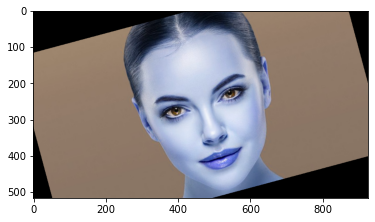

In [146]:
display(img_15)

In [165]:
x = openpifpafFaceKey(img_15,emotion = "disgust")

In [139]:
allPath = []
directory = "FER2013/train/disgust"
for pic in listdir_nohidden(directory):
    allPath.append(directory+'/'+pic)

In [172]:
allPath = []
directory = "FER2013/test/disgust"
for pic in listdir_nohidden(directory):
    allPath.append(directory+'/'+pic)

In [173]:
df = pd.DataFrame([])
for i in allPath :
    img = cv2.imread(i)
    for j in range(7) :
        if j == 3:
            continue
        img_rotate = ndimage.rotate(img, -30+(j*10), reshape=False)
        ans = openpifpafFaceKey(img_rotate,emotion = "disgust")
        dictDf = {'Name': [i.split('/')[2] + '/' + i.split('/')[3]+str(i)],
        'Emotion': [ans[1]],
        'Landmark24': [ans[0][0]],
        'Landmark25': [ans[0][1]],
        'Landmark26': [ans[0][2]],
        'Landmark27': [ans[0][3]],
        'Landmark28': [ans[0][4]],
        'Landmark29': [ans[0][5]],
        'Landmark30': [ans[0][6]],
        'Landmark31': [ans[0][7]],
        'Landmark32': [ans[0][8]],
        'Landmark33': [ans[0][9]],
        'Landmark34': [ans[0][10]],
        'Landmark35': [ans[0][11]],
        'Landmark36': [ans[0][12]],
        'Landmark37': [ans[0][13]],
        'Landmark38': [ans[0][14]],
        'Landmark39': [ans[0][15]],
        'Landmark40': [ans[0][16]],
        'Landmark41': [ans[0][17]],
        'Landmark42': [ans[0][18]],
        'Landmark43': [ans[0][19]],
        'Landmark44': [ans[0][20]],
        'Landmark45': [ans[0][21]],    
        'Landmark46': [ans[0][22]],
        'Landmark47': [ans[0][23]],
        'Landmark48': [ans[0][24]],
        'Landmark49': [ans[0][25]],                 
        'Landmark50': [ans[0][26]],                 
        'Landmark51': [ans[0][27]],                  
        'Landmark52': [ans[0][28]],                  
        'Landmark53': [ans[0][29]],                  
        'Landmark54': [ans[0][30]],                  
        'Landmark55': [ans[0][31]],                  
        'Landmark56': [ans[0][32]],                                 
        'Landmark57': [ans[0][33]],  
        'Landmark58': [ans[0][34]],                 
        'Landmark59': [ans[0][35]],                 
        'Landmark60': [ans[0][36]],                 
        'Landmark61': [ans[0][37]],                 
        'Landmark62': [ans[0][38]],                
        'Landmark63': [ans[0][39]],                
        'Landmark64': [ans[0][40]],                
        'Landmark65': [ans[0][41]],                
        'Landmark66': [ans[0][42]],                
        'Landmark67': [ans[0][43]],                
        'Landmark68': [ans[0][44]],                
        'Landmark69': [ans[0][45]],                
        'Landmark70': [ans[0][46]],                
        'Landmark71': [ans[0][47]],                
        'Landmark72': [ans[0][48]],                
        'Landmark73': [ans[0][49]],                
        'Landmark74': [ans[0][50]],                
        'Landmark75': [ans[0][51]],                
        'Landmark76': [ans[0][52]],                
        'Landmark77': [ans[0][53]],                
        'Landmark78': [ans[0][54]],                
        'Landmark79': [ans[0][55]],                
        'Landmark80': [ans[0][56]],                
        'Landmark81': [ans[0][57]],                
        'Landmark82': [ans[0][58]],                
        'Landmark83': [ans[0][59]],                
        'Landmark84': [ans[0][60]],                
        'Landmark85': [ans[0][61]],                
        'Landmark86': [ans[0][62]],                
        'Landmark87': [ans[0][63]],                
        'Landmark88': [ans[0][64]],                
        'Landmark89': [ans[0][65]],                
        'Landmark90': [ans[0][66]],                
        'Landmark91': [ans[0][67]]}
        dfLoop = pd.DataFrame(dictDf)
        df = df.append(dfLoop)

In [174]:
df

,Name,Emotion,Landmark24,Landmark25,Landmark26,Landmark27,Landmark28,Landmark29,Landmark30,Landmark31,...,Landmark82,Landmark83,Landmark84,Landmark85,Landmark86,Landmark87,Landmark88,Landmark89,Landmark90,Landmark91
0,disgust/PublicTest_31237465.jpgFER2013/test/di...,disgust,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[11.763127, 39.66138, 0.3144066]","[11.653755, 36.40929, 0.35388643]","[16.407043, 37.831917, 0.3632662]","[20.770067, 40.129684, 0.34028357]","[21.332539, 41.09546, 0.3341288]","[21.385372, 41.854206, 0.334109]","[19.637516, 42.664093, 0.30246052]","[17.87834, 42.297726, 0.29183373]","[14.214553, 39.98242, 0.34740695]","[0.0, 0.0, 0.0]"
0,disgust/PublicTest_31237465.jpgFER2013/test/di...,disgust,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[15.017954, 40.428368, 0.340852]","[13.920825, 37.718548, 0.38060004]","[18.88866, 38.330814, 0.4108795]","[23.670454, 39.641884, 0.40588754]","[24.171139, 40.220318, 0.40964904]","[24.17981, 40.657326, 0.36900702]","[22.81274, 41.39237, 0.3552597]","[21.425924, 41.508083, 0.32122037]","[17.362154, 40.14462, 0.3456283]","[0.0, 0.0, 0.0]"
0,disgust/PublicTest_31237465.jpgFER2013/test/di...,disgust,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[16.56023, 42.971825, 0.4248056]","[15.722308, 39.946426, 0.4410376]","[20.870718, 38.801945, 0.50122863]","[26.220247, 39.315884, 0.45974043]","[26.7571, 40.217484, 0.45210755]","[26.50614, 41.211563, 0.44191736]","[25.416845, 42.85665, 0.42231095]","[23.698954, 43.19614, 0.38500506]","[19.016058, 42.266853, 0.41114104]","[0.0, 0.0, 0.0]"
0,disgust/PublicTest_31237465.jpgFER2013/test/di...,disgust,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[24.31878, 42.875126, 0.43155766]","[22.334198, 40.93047, 0.4643817]","[27.028278, 39.204628, 0.46766555]","[31.406382, 38.3395, 0.4727666]","[31.86678, 38.65316, 0.4557427]","[31.942976, 38.919903, 0.50930905]","[31.418623, 39.909245, 0.5113209]","[30.408895, 40.79025, 0.45077577]","[25.988852, 41.258183, 0.4676403]","[0.0, 0.0, 0.0]"
0,disgust/PublicTest_31237465.jpgFER2013/test/di...,disgust,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]",...,"[28.76331, 43.97543, 0.30995336]","[25.556152, 41.541283, 0.30896255]","[30.330032, 38.62177, 0.3646351]","[35.556892, 36.869663, 0.31839192]","[37.664597, 36.79746, 0.27836892]","[39.196186, 37.11871, 0.27037394]","[38.153904, 39.015606, 0.2801059]","[36.20954, 40.43248, 0.29266936]","[30.725275, 41.69898, 0.32191944]","[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,disgust/PrivateTest_53395751.jpgFER2013/test/d...,disgust,"[6.3133917, 15.190242, 0.61851186]","[5.335433, 21.318167, 0.5868832]","[4.573726, 26.742533, 0.56093913]","[4.544171, 32.27051, 0.5591799]","[6.154946, 37.361576, 0.52899796]","[7.8275795, 42.65351, 0.485779]","[10.782093, 47.078117, 0.44095415]","[0.0, 0.0, 0.0]",...,"[11.984294, 36.684464, 0.48345104]","[11.810311, 33.189213, 0.56384987]","[15.368845, 34.003098, 0.55650485]","[19.037636, 35.451324, 0.55151486]","[23.046957, 36.674076, 0.5605875]","[26.618189, 38.351345, 0.55950624]","[22.310509, 40.312927, 0.50942177]","[17.637423, 40.29241, 0.48784548]","[14.048606, 37.575813, 0.47645414]","[0.0, 0.0, 0.0]"
0,disgust/PrivateTest_53395751.jpgFER2013/test/d...,disgust,"[5.5710297, 18.008186, 0.5794823]","[5.532031, 23.73786, 0.5633821]","[5.6701813, 29.09482, 0.56262916]","[6.5211744, 34.327003, 0.5489834]","[9.2854805, 39.377525, 0.51984614]","[11.736173, 43.70444, 0.4738529

In [171]:
df.to_json("landMarkFER2013_TrainOverSam.json", orient = 'table')

In [175]:
df.to_json("landMarkFER2013_TestOverSam.json", orient = 'table')

## Train and Test

In [227]:
C=1
models = (SVC(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),          
          AdaBoostClassifier(),
          GaussianNB(),
         )

names = ["SVC",
         "K Nearest Neighbors","Decision Tree", "Random Forest", "AdaBoost","Naive Bayes"]

In [24]:
X_train = dfTrain.loc[:,'Landmark_24_x':]
X_test = dfTest.loc[:,'Landmark_24_x':]
y_train = dfTrain.loc[:,'Emotion']
y_test = dfTest.loc[:,'Emotion']


In [16]:
y_train

0         happy
1         happy
2         happy
3         happy
4         happy
         ...   
2611    disgust
2612    disgust
2613    disgust
2614    disgust
2615    disgust
Name: Emotion, Length: 28422, dtype: object

In [229]:
print ("      Classifiers: \t Accuracy:".expandtabs(44))
for name, clf in zip(names, models):     
    clf.fit(X_train,y_train) #train each model
    scores = clf.score(X_test,y_test) #evaluate each model in the test set
    print ("{:46} {:.3f} ".format(name, scores.mean()))
    
#Before Normalise

      Classifiers:                           Accuracy:
SVC                                            0.469 
K Nearest Neighbors                            0.380 
Decision Tree                                  0.393 
Random Forest                                  0.517 
AdaBoost                                       0.411 
Naive Bayes                                    0.303 


In [256]:
print ("      Classifiers: \t Accuracy:".expandtabs(44))
for name, clf in zip(names, models):     
    clf.fit(X_train,y_train) #train each model
    scores = clf.score(X_test,y_test) #evaluate each model in the test set
    print ("{:46} {:.3f} ".format(name, scores.mean()))

      Classifiers:                           Accuracy:
K Nearest Neighbors                            0.361 
Decision Tree                                  0.405 
Random Forest                                  0.346 
AdaBoost                                       0.411 
Naive Bayes                                    0.303 


### SVM

In [20]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

NameError: name 'X_train' is not defined

In [214]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [215]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [45]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.266 total time= 1.3min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.266 total time= 1.3min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.266 total time= 1.3min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.266 total time= 1.3min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.266 total time= 1.3min
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.266 total time= 1.5min
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.266 total time= 1.5min
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.266 total time= 1.6min
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.266 total time= 1.6min
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.266 total time= 1.6min
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.277 total time= 1.4min
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.318 total time= 2.1min
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.318 total time= 2.2min
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.319 total time= 2.1min
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.317 total time= 2.1min
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.321 total time= 2.6min
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.321 total time= 2.7min
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.319 total time= 2.5min
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.321 total time= 2.6min
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.320 total time= 2.6min
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.411 total time= 1.8min
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.415 total time= 1.8min
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.411 total time= 1.8min
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [216]:
grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [53]:
grid.best_estimator_

SVC(C=100, gamma=0.0001)

In [54]:
grid_predictions = grid.predict(X_test)

In [55]:
print(classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

       angry       0.42      0.42      0.42       891
     disgust       0.56      0.21      0.30       107
        fear       0.34      0.22      0.26       887
       happy       0.76      0.82      0.79      1703
     neutral       0.43      0.61      0.50      1153
         sad       0.42      0.36      0.39      1135
    surprise       0.62      0.55      0.59       638

    accuracy                           0.53      6514
   macro avg       0.51      0.46      0.46      6514
weighted avg       0.52      0.53      0.52      6514



In [57]:
print(confusion_matrix(y_test,grid_predictions))

[[ 374    4   63   93  181  138   38]
 [  35   22    9    8   16   14    3]
 [ 129    6  192   79  215  182   84]
 [  70    2   36 1399  117   51   28]
 [  89    2   86   86  700  159   31]
 [ 156    3  127   98  309  412   30]
 [  45    0   57   66   85   32  353]]


### KNN

In [40]:
model = KNeighborsClassifier(3)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.47      0.70      0.56      1703
           1       0.30      0.32      0.31      1135
           2       0.29      0.23      0.26       887
           3       0.48      0.35      0.41       638
           4       0.38      0.28      0.33      1153
           5       0.34      0.17      0.23       891
           6       0.09      0.23      0.13       107

    accuracy                           0.38      6514
   macro avg       0.34      0.33      0.32      6514
weighted avg       0.38      0.38      0.37      6514



In [21]:
model = KNeighborsClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       angry       0.26      0.32      0.29       891
     disgust       0.27      0.24      0.26       107
        fear       0.29      0.27      0.28       887
       happy       0.55      0.66      0.60      1703
     neutral       0.34      0.37      0.36      1153
         sad       0.35      0.22      0.27      1135
    surprise       0.49      0.36      0.41       638

    accuracy                           0.40      6514
   macro avg       0.37      0.35      0.35      6514
weighted avg       0.39      0.40      0.39      6514



### RandomForest

In [234]:
model = RandomForestClassifier(max_depth=8, n_estimators=10, max_features=1)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       angry       0.42      0.08      0.13       891
     disgust       0.02      0.04      0.02       107
        fear       0.27      0.09      0.13       887
       happy       0.38      0.81      0.52      1703
     neutral       0.33      0.27      0.30      1153
         sad       0.33      0.23      0.27      1135
    surprise       0.44      0.34      0.38       638

    accuracy                           0.36      6514
   macro avg       0.31      0.27      0.25      6514
weighted avg       0.35      0.36      0.31      6514



In [25]:
model = RandomForestClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

       angry       0.48      0.30      0.37       891
     disgust       0.17      0.38      0.24       107
        fear       0.45      0.26      0.33       887
       happy       0.65      0.81      0.72      1703
     neutral       0.42      0.55      0.48      1153
         sad       0.42      0.40      0.41      1135
    surprise       0.68      0.57      0.62       638

    accuracy                           0.52      6514
   macro avg       0.47      0.47      0.45      6514
weighted avg       0.52      0.52      0.51      6514

[[ 263   29   53  204  183  126   33]
 [   9   41    9   17   14   16    1]
 [  82   32  229  100  198  186   60]
 [  41   44   38 1385  104   74   17]
 [  44   32   60  160  636  186   35]
 [  70   41   71  179  292  457   25]
 [  34   17   46   76   70   31  364]]


In [26]:
model.save('modelRandomForest_optimal.h5')
model.save_weights('modelRandomForest_weights.h5')

AttributeError: 'RandomForestClassifier' object has no attribute 'save'

In [258]:
models = (
          SVC(),
          KNeighborsClassifier(3),
          DecisionTreeClassifier(max_depth=8),
          RandomForestClassifier(max_depth=8, n_estimators=10, max_features=1),          
          AdaBoostClassifier(),
          GaussianNB(),
         )

names = ["SVC",
         "K Nearest Neighbors","Decision Tree", "Random Forest", "AdaBoost","Naive Bayes"]

In [259]:
print ("      Classifiers: \t Accuracy:".expandtabs(44))
for name, clf in zip(names, models):     
    clf.fit(X_train,y_train) #train each model
    scores = clf.score(X_test,y_test) #evaluate each model in the test set
    print ("{:46} {:.3f} ".format(name, scores.mean()))

      Classifiers:                           Accuracy:
SVC                                            0.469 
K Nearest Neighbors                            0.361 
Decision Tree                                  0.405 
Random Forest                                  0.350 
AdaBoost                                       0.411 
Naive Bayes                                    0.303 


## RNN Pytorch

In [233]:
# determine the supported device
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).to(device)

In [55]:
## Turn target to number
class2idx = {
    "happy":0,
    "sad":1,
    "fear":2,
    "surprise":3,
    "neutral":4,
    "angry":5,
    "disgust":6
}

idx2class = {v: k for k, v in class2idx.items()}

y_train.replace(class2idx, inplace=True)
y_test.replace(class2idx, inplace=True)

In [56]:
y_test

0       0
1       0
2       0
3       0
4       0
       ..
7173    6
7174    6
7175    6
7176    6
7177    6
Name: Emotion, Length: 6514, dtype: int64

In [33]:
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = df_to_tensor(X_train)
targetsTrain = df_to_tensor(y_train)

# create feature and targets tensor for test set.
featuresTest = df_to_tensor(X_test)
targetsTest = df_to_tensor(y_test)

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [44]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 204    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 7   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [45]:
n_epochs=1000
loss_list=[]

#n_epochs
for epoch in range(n_epochs):
    for x, y in train_loader:
      

        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)
        # calculate loss, da Cross Entropy benutzt wird muss ich in den loss Klassen vorhersagen, 
        # also Wahrscheinlichkeit pro Klasse. Das mach torch.max(y,1)[1])
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        
        
        print('epoch {}, loss {}'.format(epoch, loss.item()))

RuntimeError: input must have 3 dimensions, got 2

In [46]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(train_loader):

        train  = Variable(data)
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for test, labels in test_loader:
                test = Variable(test)
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))

RuntimeError: input must have 3 dimensions, got 2

In [37]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
2611    6
2612    6
2613    6
2614    6
2615    6
Name: Emotion, Length: 28422, dtype: int64

## Get Dummies Y and reset index

In [29]:
y_train = pd.get_dummies(dfTrain.loc[:,'Emotion'])
y_test = pd.get_dummies(dfTest.loc[:,'Emotion'])
X_train = dfTrain.loc[:,'Landmark_24_x':]
X_test = dfTest.loc[:,'Landmark_24_x':]
y_train = y_train.values
y_test = y_test.values

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

X_train = X_train.reset_index()
X_train = X_train.drop('index',axis=1)

X_test = X_test.reset_index()
X_test = X_test.drop('index',axis=1)


In [30]:
X_train.shape

(28422, 204)

In [31]:
print(y_train[25000])
print(dfTrain.loc[:,'Emotion'][25000:25001])
print()
print(y_train[28000])
print(dfTrain.loc[:,'Emotion'][28000:28001])
print()
print(y_train[13000])
print(dfTrain.loc[:,'Emotion'][13000:13001])
print()
print(y_train[0])
print(dfTrain.loc[:,'Emotion'][0:1])
print()
print(y_train[20000])
print(dfTrain.loc[:,'Emotion'][20000:20001])
print()
print(y_train[10000])
print(dfTrain.loc[:,'Emotion'][10000:10001])
print()
print(y_train[16000])
print(dfTrain.loc[:,'Emotion'][16000:16001])

[1. 0. 0. 0. 0. 0. 0.]
27625    angry
Name: Emotion, dtype: object

[0. 1. 0. 0. 0. 0. 0.]
2158    disgust
Name: Emotion, dtype: object

[0. 0. 1. 0. 0. 0. 0.]
14008    fear
Name: Emotion, dtype: object

[0. 0. 0. 1. 0. 0. 0.]
0    happy
Name: Emotion, dtype: object

[0. 0. 0. 0. 1. 0. 0.]
22275    neutral
Name: Emotion, dtype: object

[0. 0. 0. 0. 0. 1. 0.]
10590    sad
Name: Emotion, dtype: object

[0. 0. 0. 0. 0. 0. 1.]
17696    surprise
Name: Emotion, dtype: object


## Prepare X for RNN

In [32]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [33]:
X_train.shape

(28422, 204)

In [27]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [28]:
X_train.shape[2]

204

In [44]:
y_train.shape

(28422, 7)

## RNN keras

In [37]:
model = Sequential()

model.add(LSTM(204, activation='relu', input_shape=(1, X_train.shape[2])))


model.add(Dense(102, activation='relu'))


model.add(Dense(51, activation='relu'))


model.add(Dense(25, activation='relu'))


model.add(Dense(13, activation='relu'))


model.add(Dense(y_train.shape[1],activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 204)               333744    
_________________________________________________________________
dense_32 (Dense)             (None, 102)               20910     
_________________________________________________________________
dense_33 (Dense)             (None, 51)                5253      
_________________________________________________________________
dense_34 (Dense)             (None, 25)                1300      
_________________________________________________________________
dense_35 (Dense)             (None, 13)                338       
_________________________________________________________________
dense_36 (Dense)             (None, 7)                 98        
Total params: 361,643
Trainable params: 361,643
Non-trainable params: 0
________________________________________________

In [38]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Fitting the RNN to the Training set
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
889/889 [==============================] - 4s 4ms/step - loss: 1.8604 - accuracy: 0.2517 - val_loss: 1.7815 - val_accuracy: 0.3021
Epoch 2/600
889/889 [==============================] - 3s 3ms/step - loss: 1.7628 - accuracy: 0.3058 - val_loss: 1.6103 - val_accuracy: 0.3694
Epoch 3/600
889/889 [==============================] - 4s 4ms/step - loss: 1.6230 - accuracy: 0.3769 - val_loss: 1.6972 - val_accuracy: 0.3324
Epoch 4/600
889/889 [==============================] - 3s 4ms/step - loss: 1.5463 - accuracy: 0.4086 - val_loss: 1.5661 - val_accuracy: 0.4113
Epoch 5/600
889/889 [==============================] - 4s 5ms/step - loss: 1.5057 - accuracy: 0.4285 - val_loss: 1.4626 - val_accuracy: 0.4437
Epoch 6/600
889/889 [==============================] - 3s 4ms/step - loss: 1.4650 - accuracy: 0.4510 - val_loss: 1.4766 - val_accuracy: 0.4297
Epoch 7/600
889/889 [==============================] - 4s 4ms/step - loss: 1.4408 - accuracy: 0.4583 - val_loss: 1.4727 - val_accuracy: 0.4348

In [39]:
y_pred= model.predict(X_test)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.52      0.25      0.34       891
           1       0.11      0.15      0.12       107
           2       0.34      0.08      0.14       887
           3       0.63      0.90      0.74      1703
           4       0.37      0.59      0.45      1153
           5       0.40      0.39      0.39      1135
           6       0.75      0.40      0.52       638

    accuracy                           0.49      6514
   macro avg       0.44      0.39      0.39      6514
weighted avg       0.49      0.49      0.46      6514

[[ 226   34   35  208  206  159   23]
 [  14   16    3   21   28   24    1]
 [  66   31   75  141  305  223   46]
 [  24    5   24 1532   77   35    6]
 [  22   20   14  233  676  184    4]
 [  59   27   23  208  375  438    5]
 [  22   19   47   85  176   34  255]]


In [51]:
model = Sequential()

model.add(LSTM(408, return_sequences=True, activation='relu', input_shape=(1, X_train.shape[2])))
model.add(LSTM(408, return_sequences=True, activation='relu'))
model.add(LSTM(408, activation='relu'))

model.add(Dense(204, activation='relu'))


model.add(Dense(102, activation='relu'))


model.add(Dense(51, activation='relu'))


model.add(Dense(25, activation='relu'))


model.add(Dense(13, activation='relu'))


model.add(Dense(y_train.shape[1],activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 408)            1000416   
_________________________________________________________________
lstm_15 (LSTM)               (None, 1, 408)            1333344   
_________________________________________________________________
lstm_16 (LSTM)               (None, 408)               1333344   
_________________________________________________________________
dense_52 (Dense)             (None, 204)               83436     
_________________________________________________________________
dense_53 (Dense)             (None, 102)               20910     
_________________________________________________________________
dense_54 (Dense)             (None, 51)                5253      
_________________________________________________________________
dense_55 (Dense)             (None, 25)              

In [52]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Fitting the RNN to the Training set
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
889/889 [==============================] - 28s 29ms/step - loss: 1.8709 - accuracy: 0.2513 - val_loss: 1.7743 - val_accuracy: 0.3055
Epoch 2/600
889/889 [==============================] - 25s 28ms/step - loss: 1.7858 - accuracy: 0.2851 - val_loss: 1.7693 - val_accuracy: 0.3121
Epoch 3/600
889/889 [==============================] - 26s 29ms/step - loss: 1.7171 - accuracy: 0.3214 - val_loss: 1.6683 - val_accuracy: 0.3684
Epoch 4/600
889/889 [==============================] - 25s 28ms/step - loss: 1.6610 - accuracy: 0.3502 - val_loss: 1.5772 - val_accuracy: 0.4024
Epoch 5/600
889/889 [==============================] - 24s 27ms/step - loss: 1.6225 - accuracy: 0.3686 - val_loss: 1.5425 - val_accuracy: 0.4223
Epoch 6/600
889/889 [==============================] - 24s 27ms/step - loss: 1.5738 - accuracy: 0.3902 - val_loss: 1.5875 - val_accuracy: 0.3947
Epoch 7/600
889/889 [==============================] - 25s 28ms/step - loss: 1.5473 - accuracy: 0.4002 - val_loss: 1.5177 - val_ac

In [50]:
y_pred= model.predict(X_test)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38       891
           1       0.14      0.40      0.20       107
           2       0.30      0.21      0.25       887
           3       0.69      0.87      0.77      1703
           4       0.41      0.45      0.43      1153
           5       0.39      0.38      0.38      1135
           6       0.67      0.50      0.57       638

    accuracy                           0.50      6514
   macro avg       0.44      0.45      0.43      6514
weighted avg       0.49      0.50      0.49      6514

[[ 288   69   73  137  148  153   23]
 [  13   43   14   16   13    6    2]
 [  88   44  184  109  193  201   68]
 [  33   27   38 1474   50   67   14]
 [  68   40   96  189  521  212   27]
 [  86   72  107  149  273  426   22]
 [  39   19   98   69   67   30  316]]


## ANN with Dropout

In [43]:
model=Sequential()

model.add(Dense(204,input_shape=(204,),activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(408,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(916,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(408,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(204,activation='relu'))
#model.add(Dropout(0.2))


model.add(Dense(102,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(51,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(25,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(13,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(7,activation='softmax'))

In [44]:
# Compiling the ANN
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Fitting the ANN to the Training set
model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
889/889 [==============================] - 7s 8ms/step - loss: 1.8646 - accuracy: 0.2428 - val_loss: 1.7428 - val_accuracy: 0.3093
Epoch 2/600
889/889 [==============================] - 7s 8ms/step - loss: 1.7670 - accuracy: 0.3025 - val_loss: 1.7415 - val_accuracy: 0.3519
Epoch 3/600
889/889 [==============================] - 9s 10ms/step - loss: 1.6795 - accuracy: 0.3502 - val_loss: 1.6605 - val_accuracy: 0.3486
Epoch 4/600
889/889 [==============================] - 9s 10ms/step - loss: 1.6532 - accuracy: 0.3600 - val_loss: 1.5424 - val_accuracy: 0.4211
Epoch 5/600
889/889 [==============================] - 8s 9ms/step - loss: 1.6033 - accuracy: 0.3837 - val_loss: 1.5317 - val_accuracy: 0.4254
Epoch 6/600
889/889 [==============================] - 8s 9ms/step - loss: 1.5781 - accuracy: 0.3920 - val_loss: 1.5299 - val_accuracy: 0.3932
Epoch 7/600
889/889 [==============================] - 11s 13ms/step - loss: 1.5297 - accuracy: 0.4190 - val_loss: 1.4788 - val_accuracy: 0.

In [36]:
y_pred= model.predict(X_test)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.26      0.09      0.13       891
           1       0.02      0.08      0.03       107
           2       0.24      0.02      0.04       887
           3       0.47      0.90      0.62      1703
           4       0.30      0.51      0.38      1153
           5       0.28      0.04      0.07      1135
           6       0.72      0.27      0.40       638

    accuracy                           0.38      6514
   macro avg       0.33      0.27      0.24      6514
weighted avg       0.36      0.38      0.30      6514

[[  81   68   10  414  276   25   17]
 [   4    9    1   54   35    3    1]
 [  77   97   17  300  337   29   30]
 [  26   76    2 1539   52    5    3]
 [  17   87    6  410  588   36    9]
 [  11  150    4  453  466   44    7]
 [  97   25   32  114  180   16  174]]


In [39]:
# Compiling the ANN
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Fitting the ANN to the Training set
history = model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600
889/889 [==============================] - 8s 9ms/step - loss: 1.9104 - accuracy: 0.2087 - val_loss: 1.8223 - val_accuracy: 0.2700
Epoch 2/600
889/889 [==============================] - 8s 8ms/step - loss: 1.8591 - accuracy: 0.2470 - val_loss: 1.8013 - val_accuracy: 0.2918
Epoch 3/600
889/889 [==============================] - 8s 9ms/step - loss: 1.8378 - accuracy: 0.2588 - val_loss: 1.7765 - val_accuracy: 0.2929
Epoch 4/600
889/889 [==============================] - 8s 9ms/step - loss: 1.8272 - accuracy: 0.2651 - val_loss: 1.7379 - val_accuracy: 0.3256
Epoch 5/600
889/889 [==============================] - 8s 9ms/step - loss: 1.8007 - accuracy: 0.2805 - val_loss: 1.8022 - val_accuracy: 0.2923
Epoch 6/600
889/889 [==============================] - 8s 8ms/step - loss: 1.8448 - accuracy: 0.2661 - val_loss: 1.8114 - val_accuracy: 0.2711
Epoch 7/600
889/889 [==============================] - 8s 9ms/step - loss: 1.8352 - accuracy: 0.2705 - val_loss: 1.7753 - val_accuracy: 0.2780

Epoch 58/600
889/889 [==============================] - 7s 8ms/step - loss: 1.7586 - accuracy: 0.3031 - val_loss: 1.8487 - val_accuracy: 0.2733
Epoch 59/600
889/889 [==============================] - 7s 8ms/step - loss: 1.6872 - accuracy: 0.3306 - val_loss: 1.8215 - val_accuracy: 0.2863
Epoch 60/600
889/889 [==============================] - 7s 8ms/step - loss: 1.6959 - accuracy: 0.3261 - val_loss: 1.9090 - val_accuracy: 0.2717
Epoch 61/600
889/889 [==============================] - 7s 8ms/step - loss: 1.6941 - accuracy: 0.3333 - val_loss: 1.9201 - val_accuracy: 0.2768
Epoch 62/600
889/889 [==============================] - 8s 9ms/step - loss: 1.6975 - accuracy: 0.3317 - val_loss: 1.6249 - val_accuracy: 0.3506
Epoch 63/600
889/889 [==============================] - 7s 8ms/step - loss: 1.7085 - accuracy: 0.3253 - val_loss: 1.6073 - val_accuracy: 0.3566
Epoch 64/600
889/889 [==============================] - 7s 8ms/step - loss: 1.6837 - accuracy: 0.3386 - val_loss: 1.6056 - val_accuracy:

In [42]:
y_pred= model.predict(X_test)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       891
           1       0.00      0.00      0.00       107
           2       0.50      0.00      0.00       887
           3       0.47      0.94      0.63      1703
           4       0.22      0.58      0.32      1153
           5       0.03      0.00      0.00      1135
           6       0.00      0.00      0.00       638

    accuracy                           0.35      6514
   macro avg       0.17      0.22      0.14      6514
weighted avg       0.24      0.35      0.22      6514

[[   0    0    0  368  514    9    0]
 [   0    0    0   39   68    0    0]
 [   0    0    1  319  549   18    0]
 [   0    0    0 1604   98    1    0]
 [   0    0    0  480  666    7    0]
 [   0    0    0  470  662    3    0]
 [   0    0    1  127  443   67    0]]


/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

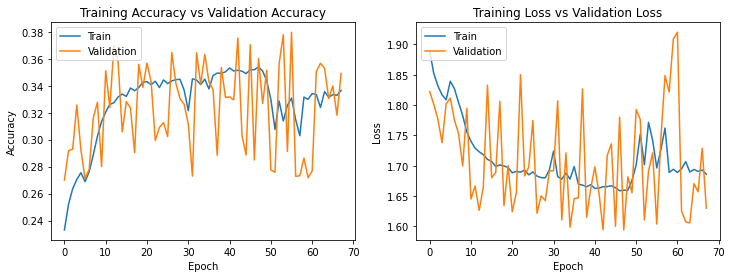

In [41]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Compiling the ANN
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


history = model.fit(x = train_generator,epochs = 600,validation_data = validation_generator,callbacks=[early_stop])

Epoch 1/600
90/90 [==============================] - 11s 117ms/step - loss: 1.5984 - accuracy: 0.3738 - val_loss: 1.5687 - val_accuracy: 0.3980
Epoch 2/600
90/90 [==============================] - 9s 104ms/step - loss: 1.6106 - accuracy: 0.3642 - val_loss: 1.5546 - val_accuracy: 0.3918
Epoch 3/600
90/90 [==============================] - 9s 104ms/step - loss: 1.6006 - accuracy: 0.3736 - val_loss: 1.5709 - val_accuracy: 0.3771
Epoch 4/600
90/90 [==============================] - 9s 96ms/step - loss: 1.6089 - accuracy: 0.3678 - val_loss: 1.5504 - val_accuracy: 0.3876
Epoch 5/600
90/90 [==============================] - 8s 90ms/step - loss: 1.6104 - accuracy: 0.3659 - val_loss: 1.5662 - val_accuracy: 0.3855
Epoch 6/600
90/90 [==============================] - 8s 84ms/step - loss: 1.6017 - accuracy: 0.3673 - val_loss: 1.5727 - val_accuracy: 0.3820
Epoch 7/600
90/90 [==============================] - 8s 87ms/step - loss: 1.6064 - accuracy: 0.3646 - val_loss: 1.5503 - val_accuracy: 0.3904
Ep

90/90 [==============================] - 7s 79ms/step - loss: 1.5110 - accuracy: 0.4148 - val_loss: 1.5237 - val_accuracy: 0.4099
Epoch 116/600
90/90 [==============================] - 7s 78ms/step - loss: 1.5023 - accuracy: 0.4179 - val_loss: 1.5199 - val_accuracy: 0.4085
Epoch 117/600
90/90 [==============================] - 7s 81ms/step - loss: 1.5083 - accuracy: 0.4138 - val_loss: 1.5175 - val_accuracy: 0.4169
Epoch 118/600
90/90 [==============================] - 7s 78ms/step - loss: 1.5129 - accuracy: 0.4189 - val_loss: 1.5135 - val_accuracy: 0.4134
Epoch 119/600
90/90 [==============================] - 7s 78ms/step - loss: 1.5077 - accuracy: 0.4129 - val_loss: 1.5026 - val_accuracy: 0.4232
Epoch 120/600
90/90 [==============================] - 7s 79ms/step - loss: 1.5081 - accuracy: 0.4175 - val_loss: 1.5133 - val_accuracy: 0.4085
Epoch 121/600
90/90 [==============================] - 7s 79ms/step - loss: 1.5086 - accuracy: 0.4131 - val_loss: 1.5110 - val_accuracy: 0.4134
Epoch 

Epoch 172/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4776 - accuracy: 0.4264 - val_loss: 1.4971 - val_accuracy: 0.4323
Epoch 173/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4710 - accuracy: 0.4277 - val_loss: 1.5049 - val_accuracy: 0.4260
Epoch 174/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4833 - accuracy: 0.4227 - val_loss: 1.5036 - val_accuracy: 0.4260
Epoch 175/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4766 - accuracy: 0.4267 - val_loss: 1.4992 - val_accuracy: 0.4183
Epoch 176/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4832 - accuracy: 0.4267 - val_loss: 1.4953 - val_accuracy: 0.4344
Epoch 177/600
90/90 [==============================] - 8s 90ms/step - loss: 1.4800 - accuracy: 0.4301 - val_loss: 1.4960 - val_accuracy: 0.4351
Epoch 178/600
90/90 [==============================] - 8s 92ms/step - loss: 1.4853 - accuracy: 0.4209 - val_loss: 1.4843 - val_accuracy:

Epoch 229/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4521 - accuracy: 0.4358 - val_loss: 1.4835 - val_accuracy: 0.4316
Epoch 230/600
90/90 [==============================] - 7s 83ms/step - loss: 1.4503 - accuracy: 0.4368 - val_loss: 1.4794 - val_accuracy: 0.4427
Epoch 231/600
90/90 [==============================] - 7s 80ms/step - loss: 1.4498 - accuracy: 0.4372 - val_loss: 1.4828 - val_accuracy: 0.4420
Epoch 232/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4547 - accuracy: 0.4403 - val_loss: 1.4773 - val_accuracy: 0.4504
Epoch 233/600
90/90 [==============================] - 7s 78ms/step - loss: 1.4544 - accuracy: 0.4342 - val_loss: 1.4764 - val_accuracy: 0.4365
Epoch 234/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4464 - accuracy: 0.4419 - val_loss: 1.5100 - val_accuracy: 0.4113
Epoch 235/600
90/90 [==============================] - 7s 79ms/step - loss: 1.4582 - accuracy: 0.4349 - val_loss: 1.4718 - val_accuracy:

Epoch 286/600
90/90 [==============================] - 10s 115ms/step - loss: 1.4312 - accuracy: 0.4496 - val_loss: 1.4920 - val_accuracy: 0.4267
Epoch 287/600
90/90 [==============================] - 10s 112ms/step - loss: 1.4436 - accuracy: 0.4405 - val_loss: 1.4856 - val_accuracy: 0.4448
Epoch 288/600
90/90 [==============================] - 9s 104ms/step - loss: 1.4510 - accuracy: 0.4335 - val_loss: 1.4814 - val_accuracy: 0.4448
Epoch 289/600
90/90 [==============================] - 9s 100ms/step - loss: 1.4478 - accuracy: 0.4371 - val_loss: 1.4701 - val_accuracy: 0.4358
Epoch 290/600
90/90 [==============================] - 9s 96ms/step - loss: 1.4299 - accuracy: 0.4517 - val_loss: 1.5009 - val_accuracy: 0.4232
Epoch 291/600
90/90 [==============================] - 9s 96ms/step - loss: 1.4350 - accuracy: 0.4430 - val_loss: 1.4686 - val_accuracy: 0.4330
Epoch 292/600
90/90 [==============================] - 8s 86ms/step - loss: 1.4366 - accuracy: 0.4392 - val_loss: 1.4958 - val_acc

Confusion Matrix
[[  80    0  125 1465  695  578  253]
 [  13    0   14  141   90   60   31]
 [  70    0  120 1494  764  562  268]
 [ 109    0  226 2581 1336  993  527]
 [  96    0  123 1862  884  676  331]
 [  72    0  130 1811  918  593  340]
 [  54    0   76 1170  549  455  233]]
Classification Report
              precision    recall  f1-score   support

       angry       0.16      0.03      0.04      3196
     disgust       0.00      0.00      0.00       349
        fear       0.15      0.04      0.06      3278
       happy       0.25      0.45      0.32      5772
     neutral       0.17      0.22      0.19      3972
         sad       0.15      0.15      0.15      3864
    surprise       0.12      0.09      0.10      2537

    accuracy                           0.20     22968
   macro avg       0.14      0.14      0.12     22968
weighted avg       0.17      0.20      0.16     22968



/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

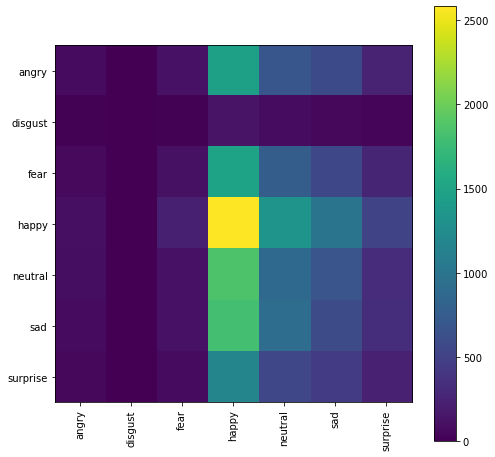

In [25]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[  7   0   6  76  47  37  18]
 [  1   0   1   8   6   3   3]
 [  6   0   5  84  47  38  24]
 [  9   0  10 157  79  57  42]
 [  4   0   8  91  77  44  22]
 [  6   0   4 114  64  36  25]
 [  3   0   4  74  34  34  17]]
Classification Report
              precision    recall  f1-score   support

       angry       0.19      0.04      0.06       191
     disgust       0.00      0.00      0.00        22
        fear       0.13      0.02      0.04       204
       happy       0.26      0.44      0.33       354
     neutral       0.22      0.31      0.26       246
         sad       0.14      0.14      0.14       249
    surprise       0.11      0.10      0.11       166

    accuracy                           0.21      1432
   macro avg       0.15      0.15      0.13      1432
weighted avg       0.18      0.21      0.18      1432



/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

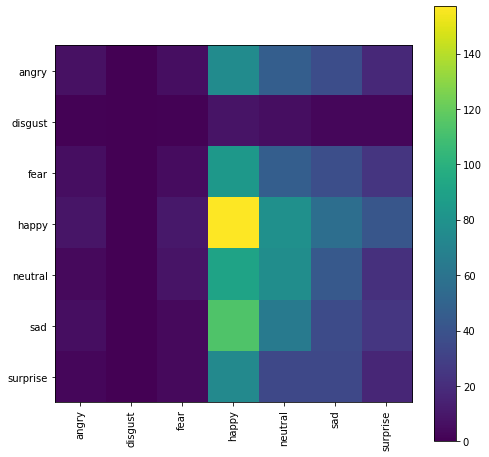

In [26]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(validation_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [27]:
y_pred= model.predict(validation_generator)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

NameError: name 'y_test' is not defined

In [20]:
model=Sequential()
model.add(Flatten()) 

model.add(Dense(2304, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(1152, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(576, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(288, kernel_initializer = 'uniform',activation='relu'))


model.add(Dense(10, kernel_initializer = 'uniform',activation='relu'))


model.add(Dense(102, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(51, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(25, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(13, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(7, kernel_initializer = 'uniform',activation='softmax'))

In [21]:
# Compiling the ANN
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


history = model.fit(x = train_generator,epochs = 600,validation_data = validation_generator,callbacks=[early_stop])

Epoch 1/600
90/90 [==============================] - 17s 181ms/step - loss: 1.9200 - accuracy: 0.2426 - val_loss: 1.8168 - val_accuracy: 0.2472
Epoch 2/600
90/90 [==============================] - 15s 167ms/step - loss: 1.8020 - accuracy: 0.2566 - val_loss: 1.8012 - val_accuracy: 0.2472
Epoch 3/600
90/90 [==============================] - 15s 169ms/step - loss: 1.7932 - accuracy: 0.2512 - val_loss: 1.7791 - val_accuracy: 0.2486
Epoch 4/600
90/90 [==============================] - 15s 172ms/step - loss: 1.7839 - accuracy: 0.2590 - val_loss: 1.7584 - val_accuracy: 0.2633
Epoch 5/600
90/90 [==============================] - 15s 161ms/step - loss: 1.7707 - accuracy: 0.2680 - val_loss: 1.7539 - val_accuracy: 0.2682
Epoch 6/600
90/90 [==============================] - 16s 181ms/step - loss: 1.7670 - accuracy: 0.2732 - val_loss: 1.7220 - val_accuracy: 0.3017
Epoch 7/600
90/90 [==============================] - 16s 176ms/step - loss: 1.7441 - accuracy: 0.2937 - val_loss: 1.7138 - val_accuracy:

Confusion Matrix
[[ 21   0  38  51  29  32  20]
 [  1   0   2   3   5   6   5]
 [ 24   3  37  60  34  31  15]
 [ 40   0  52 114  78  36  34]
 [ 29   1  45  74  47  32  18]
 [ 36   0  36  64  47  47  19]
 [ 22   2  26  38  38  25  15]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.11      0.12       191
     disgust       0.00      0.00      0.00        22
        fear       0.16      0.18      0.17       204
       happy       0.28      0.32      0.30       354
     neutral       0.17      0.19      0.18       246
         sad       0.22      0.19      0.21       249
    surprise       0.12      0.09      0.10       166

    accuracy                           0.20      1432
   macro avg       0.15      0.15      0.15      1432
weighted avg       0.19      0.20      0.19      1432



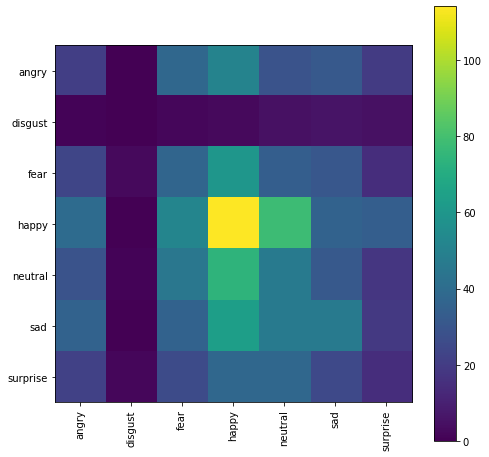

In [24]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(validation_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## ANN Without dropout

In [27]:
model=Sequential()
#model.add(Flatten()) 


model.add(Dense(204,input_shape=(204,), kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(102, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(51, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(25, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(13, kernel_initializer = 'uniform',activation='relu'))

model.add(Dense(7, kernel_initializer = 'uniform',activation='softmax'))

In [28]:
# Compiling the ANN
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Fitting the ANN to the Training set
history = model.fit(x=X_train, 
          y=y_train, 
          epochs=600,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/600


ValueError: in user code:

    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 7) are incompatible


In [37]:
y_pred= model.predict(X_test)
y_test_class=np.argmax(y_test,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.43      0.40      0.42       891
           1       0.09      0.19      0.12       107
           2       0.43      0.07      0.12       887
           3       0.80      0.81      0.81      1703
           4       0.38      0.69      0.49      1153
           5       0.42      0.35      0.38      1135
           6       0.64      0.56      0.59       638

    accuracy                           0.52      6514
   macro avg       0.46      0.44      0.42      6514
weighted avg       0.53      0.52      0.50      6514

[[ 360   49   28   86  218  120   30]
 [  37   20    1    9   26    9    5]
 [ 136   33   63   64  295  207   89]
 [  47   22   12 1386  173   43   20]
 [  85   34    8   50  793  154   29]
 [ 131   56   13   73  434  396   32]
 [  37   13   20   59  128   24  357]]


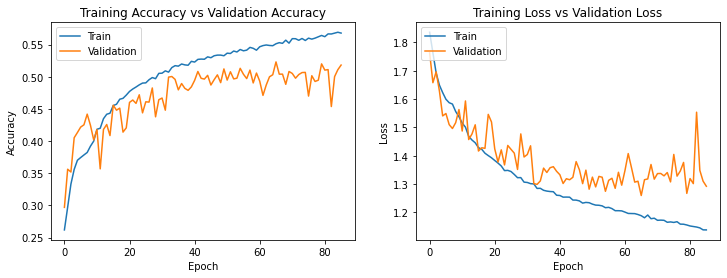

In [39]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [40]:
model.save('modelANN_NoDrop_optimal.h5')
model.save_weights('modelANN_NoDrop_weights.h5')

In [68]:
model.predict(X_test.head(1))

array([[0.01497223, 0.00175428, 0.00753636, 0.8749215 , 0.07188366,
        0.02119073, 0.00774126]], dtype=float32)

In [71]:
type(X_test.head(1))

pandas.core.frame.DataFrame

In [72]:
print(y_train[25000])
print(dfTrain.loc[:,'Emotion'][25000:25001])
print()
print(y_train[28000])
print(dfTrain.loc[:,'Emotion'][28000:28001])
print()
print(y_train[13000])
print(dfTrain.loc[:,'Emotion'][13000:13001])
print()
print(y_train[0])
print(dfTrain.loc[:,'Emotion'][0:1])
print()
print(y_train[20000])
print(dfTrain.loc[:,'Emotion'][20000:20001])
print()
print(y_train[10000])
print(dfTrain.loc[:,'Emotion'][10000:10001])
print()
print(y_train[16000])
print(dfTrain.loc[:,'Emotion'][16000:16001])

[1. 0. 0. 0. 0. 0. 0.]
27625    angry
Name: Emotion, dtype: object

[0. 1. 0. 0. 0. 0. 0.]
2158    disgust
Name: Emotion, dtype: object

[0. 0. 1. 0. 0. 0. 0.]
14008    fear
Name: Emotion, dtype: object

[0. 0. 0. 1. 0. 0. 0.]
0    happy
Name: Emotion, dtype: object

[0. 0. 0. 0. 1. 0. 0.]
22275    neutral
Name: Emotion, dtype: object

[0. 0. 0. 0. 0. 1. 0.]
10590    sad
Name: Emotion, dtype: object

[0. 0. 0. 0. 0. 0. 1.]
17696    surprise
Name: Emotion, dtype: object


In [ ]:
class2idx = {
    "angry":0,
    "disgust":1,
    "fear":2,
    "happy":3,
    "neutral":4,
    "sad":5,
    "surprise":6
}

## CNN KAGGLE

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [18]:
train_dir = "FER2013/train" #passing the path with training images
test_dir = "FER2013/test"   #passing the path with testing images

In [19]:
img_size = 48

In [20]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [21]:
train_datagen = ImageDataGenerator(
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [19]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 256,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 256,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [87]:
model= Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
    
model.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#model.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(64,activation = 'relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))
    
#model.add(Dense(512,activation = 'relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [88]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_23 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_24 (Batc (None, 24, 24, 128)      

In [89]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)


history = model.fit(x = train_generator,epochs = 600,validation_data = validation_generator,callbacks=[early_stop])

Epoch 1/600
90/90 [==============================] - 327s 4s/step - loss: 3.8952 - accuracy: 0.1926 - val_loss: 3.8948 - val_accuracy: 0.1718
Epoch 2/600
90/90 [==============================] - 318s 4s/step - loss: 3.4322 - accuracy: 0.2935 - val_loss: 4.6251 - val_accuracy: 0.1432
Epoch 3/600
90/90 [==============================] - 313s 3s/step - loss: 3.2418 - accuracy: 0.3265 - val_loss: 5.5938 - val_accuracy: 0.1173
Epoch 4/600
90/90 [==============================] - 311s 3s/step - loss: 3.0440 - accuracy: 0.3524 - val_loss: 6.9228 - val_accuracy: 0.1110
Epoch 5/600
90/90 [==============================] - 312s 3s/step - loss: 2.8383 - accuracy: 0.3862 - val_loss: 5.4332 - val_accuracy: 0.1718
Epoch 6/600
90/90 [==============================] - 313s 3s/step - loss: 2.6599 - accuracy: 0.4062 - val_loss: 3.5164 - val_accuracy: 0.2814
Epoch 7/600
90/90 [==============================] - 312s 3s/step - loss: 2.5022 - accuracy: 0.4233 - val_loss: 2.5632 - val_accuracy: 0.3736
Epoch 

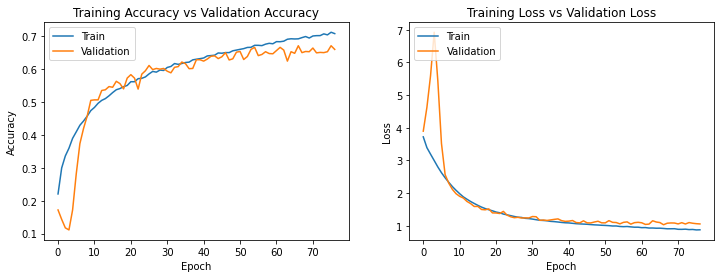

In [90]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [91]:
model.save('modelCNN_V1_optimal.h5')
model.save_weights('modelCNN_V1_weights.h5')

In [92]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

6/6 [==============================] - 8s 1s/step - loss: 1.0546 - accuracy: 0.6606
final train accuracy = 75.83 , validation accuracy = 66.06


Confusion Matrix
[[ 412   43  360  835  703  475  368]
 [  48    3   39   83   83   54   39]
 [ 392   49  391  833  789  486  338]
 [ 778   72  670 1598 1273  754  627]
 [ 547   69  434 1020  860  621  421]
 [ 484   45  457 1020  889  551  418]
 [ 326   25  311  689  534  345  307]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13      3196
     disgust       0.01      0.01      0.01       349
        fear       0.15      0.12      0.13      3278
       happy       0.26      0.28      0.27      5772
     neutral       0.17      0.22      0.19      3972
         sad       0.17      0.14      0.15      3864
    surprise       0.12      0.12      0.12      2537

    accuracy                           0.18     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.18      0.18      0.18     22968



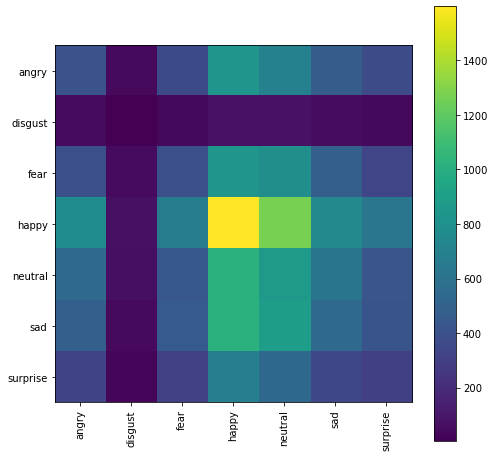

In [93]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[30  2 19 54 39 31 16]
 [ 0  0  3  5  9  4  1]
 [33  2 28 47 48 29 17]
 [46  4 39 80 96 45 44]
 [42  3 24 63 59 32 23]
 [46  1 24 77 53 28 20]
 [17  3 16 34 41 22 33]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.16      0.15       191
     disgust       0.00      0.00      0.00        22
        fear       0.18      0.14      0.16       204
       happy       0.22      0.23      0.22       354
     neutral       0.17      0.24      0.20       246
         sad       0.15      0.11      0.13       249
    surprise       0.21      0.20      0.21       166

    accuracy                           0.18      1432
   macro avg       0.15      0.15      0.15      1432
weighted avg       0.18      0.18      0.18      1432



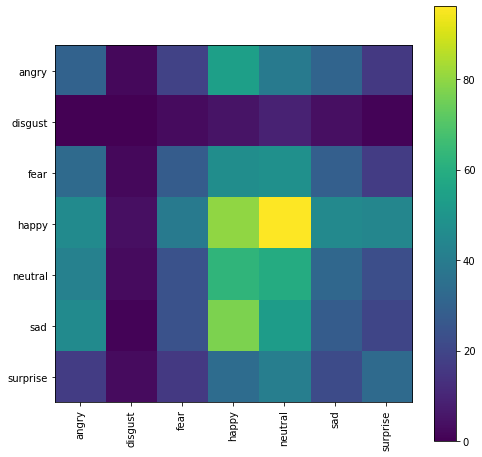

In [94]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(validation_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## RESNET 

In [59]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    rescale = 1./255,
                                    #zoom_range = 0.2,
                                    rotation_range= 5, 
                                    shear_range= 0.2,
                                   fill_mode = 'nearest'
                                    )
test_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(
                        train_dir,
                        target_size=(48,48),
                        batch_size=64,
                        class_mode='categorical',
                        subset = "training")
test_generator = test_datagen.flow_from_directory(
                        test_dir,
                        target_size=(48,48),
                        batch_size=64,
                        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [60]:
base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')

len(base_model.layers)

175

In [61]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [62]:
# Freezing layers 
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [63]:
# Build model on the top of base model
model = Sequential()

model.add(base_model)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(BatchNormalization())

# fully connected layer-1
model.add(Dense(128, kernel_initializer = 'he_uniform',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fully connected layer-2
model.add(Dense(64, kernel_initializer = 'he_uniform',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fully connected layer-3
model.add(Dense(32, kernel_initializer = 'he_uniform',activation='relu'))
model.add(BatchNormalization())

# output layer
model.add(Dense(7, activation = 'softmax'))

# model Summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout_11 (Dropout)         (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 8192)              32768     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               1048704   
_________________________________________________________________
batch_normalization_17 (Batc (None, 128)               512       
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)              

In [64]:
# function to calculate f1_score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [65]:
# evaluation metrics
from tensorflow.keras.metrics import AUC, BinaryAccuracy, Precision, Recall
metric = [BinaryAccuracy(name = 'accuracy'), 
           Precision(name = 'precision'), 
           Recall(name = 'recall'), 
           AUC(name = 'AUC'),
           ]

In [66]:
earlystop = EarlyStopping(patience=20, 
                          verbose=1)
#                           restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=20, 
                              verbose=1,
                              min_lr=1e-10)
#                               min_delta=0.0001)
callbacks = [earlystop,reduce_lr]

In [67]:
# compile model
model.compile(optimizer= 'Adam', loss='categorical_crossentropy', metrics=metric)

In [68]:
# model fitting
history = model.fit(x = train_generator,epochs = 600,validation_data = test_generator,callbacks=callbacks)

Epoch 1/600
449/449 [==============================] - 259s 571ms/step - loss: 2.0757 - accuracy: 0.8488 - precision: 0.1815 - recall: 0.0147 - AUC: 0.5751 - val_loss: 1.7713 - val_accuracy: 0.8570 - val_precision: 0.4706 - val_recall: 0.0089 - val_AUC: 0.6820
Epoch 2/600
449/449 [==============================] - 256s 570ms/step - loss: 1.7861 - accuracy: 0.8569 - precision: 0.4042 - recall: 0.0037 - AUC: 0.6762 - val_loss: 1.7522 - val_accuracy: 0.8563 - val_precision: 0.4476 - val_recall: 0.0244 - val_AUC: 0.6986
Epoch 3/600
449/449 [==============================] - 231s 514ms/step - loss: 1.7475 - accuracy: 0.8572 - precision: 0.5148 - recall: 0.0107 - AUC: 0.6953 - val_loss: 1.9849 - val_accuracy: 0.8269 - val_precision: 0.2963 - val_recall: 0.1541 - val_AUC: 0.6727
Epoch 4/600
449/449 [==============================] - 232s 516ms/step - loss: 1.7319 - accuracy: 0.8568 - precision: 0.4647 - recall: 0.0144 - AUC: 0.7042 - val_loss: 1.7385 - val_accuracy: 0.8573 - val_precision: 0.

449/449 [==============================] - 256s 571ms/step - loss: 1.5917 - accuracy: 0.8629 - precision: 0.6243 - recall: 0.1007 - AUC: 0.7660 - val_loss: 1.5928 - val_accuracy: 0.8648 - val_precision: 0.7043 - val_recall: 0.0922 - val_AUC: 0.7669
Epoch 64/600
449/449 [==============================] - 265s 591ms/step - loss: 1.5870 - accuracy: 0.8630 - precision: 0.6293 - recall: 0.0990 - AUC: 0.7673 - val_loss: 1.6149 - val_accuracy: 0.8654 - val_precision: 0.6180 - val_recall: 0.1514 - val_AUC: 0.7585
Epoch 65/600
449/449 [==============================] - 268s 597ms/step - loss: 1.5859 - accuracy: 0.8632 - precision: 0.6293 - recall: 0.1021 - AUC: 0.7677 - val_loss: 1.5486 - val_accuracy: 0.8660 - val_precision: 0.7400 - val_recall: 0.0956 - val_AUC: 0.7827
Epoch 66/600
449/449 [==============================] - 270s 602ms/step - loss: 1.5886 - accuracy: 0.8633 - precision: 0.6336 - recall: 0.1019 - AUC: 0.7657 - val_loss: 1.6087 - val_accuracy: 0.8639 - val_precision: 0.7319 - va

449/449 [==============================] - 242s 539ms/step - loss: 1.5462 - accuracy: 0.8654 - precision: 0.6448 - recall: 0.1289 - AUC: 0.7817 - val_loss: 1.5545 - val_accuracy: 0.8669 - val_precision: 0.6150 - val_recall: 0.1818 - val_AUC: 0.7801
Epoch 126/600
449/449 [==============================] - 242s 539ms/step - loss: 1.5405 - accuracy: 0.8661 - precision: 0.6610 - recall: 0.1290 - AUC: 0.7835 - val_loss: 1.5418 - val_accuracy: 0.8677 - val_precision: 0.6503 - val_recall: 0.1604 - val_AUC: 0.7836
Epoch 127/600
449/449 [==============================] - 242s 540ms/step - loss: 1.5412 - accuracy: 0.8658 - precision: 0.6532 - recall: 0.1298 - AUC: 0.7844 - val_loss: 1.5441 - val_accuracy: 0.8665 - val_precision: 0.6588 - val_recall: 0.1353 - val_AUC: 0.7845
Epoch 128/600
449/449 [==============================] - 241s 537ms/step - loss: 1.5442 - accuracy: 0.8654 - precision: 0.6408 - recall: 0.1316 - AUC: 0.7819 - val_loss: 1.5234 - val_accuracy: 0.8696 - val_precision: 0.6860 -

In [69]:
model.save('modelRes_optimal.h5')
model.save_weights('modelRes_weights.h5')

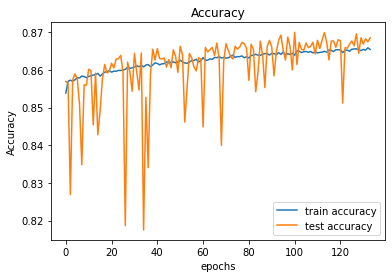

In [70]:
plt.figure(0)
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

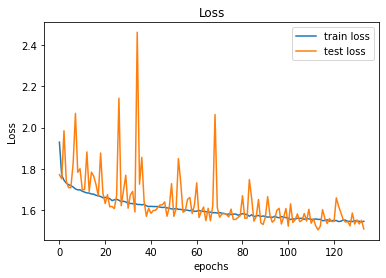

In [71]:
plt.figure(0)
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

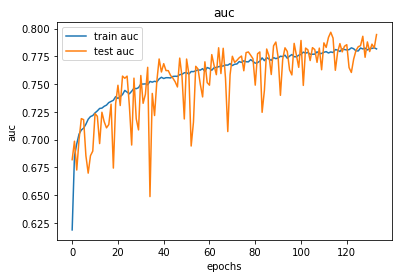

In [72]:
plt.figure(0)
plt.plot(history.history['AUC'], label= 'train auc')
plt.plot(history.history['val_AUC'], label= 'test auc')
plt.title('auc')
plt.xlabel('epochs')
plt.ylabel('auc')
plt.legend()

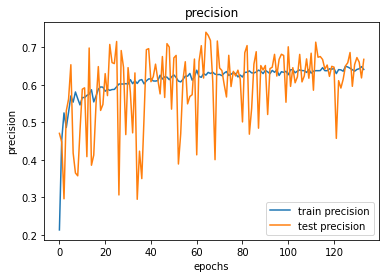

In [74]:
plt.figure(0)
plt.plot(history.history['precision'], label= 'train precision')
plt.plot(history.history['val_precision'], label= 'test precision')
plt.title('precision')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

In [75]:
train_generator

In [ ]:
test_generator

Confusion Matrix
[[ 143    9  169 1280 1144  928  322]
 [  10    0   23  152  129   90   32]
 [ 102    9  157 1280 1180 1037  332]
 [ 240   12  319 2320 2024 1718  582]
 [ 149    9  197 1569 1428 1184  429]
 [ 149    5  198 1512 1380 1188  398]
 [  86    4  138  957  932  758  296]]
Classification Report
              precision    recall  f1-score   support

       angry       0.16      0.04      0.06      3995
     disgust       0.00      0.00      0.00       436
        fear       0.13      0.04      0.06      4097
       happy       0.26      0.32      0.28      7215
     neutral       0.17      0.29      0.22      4965
         sad       0.17      0.25      0.20      4830
    surprise       0.12      0.09      0.11      3171

    accuracy                           0.19     28709
   macro avg       0.15      0.15      0.13     28709
weighted avg       0.18      0.19      0.17     28709



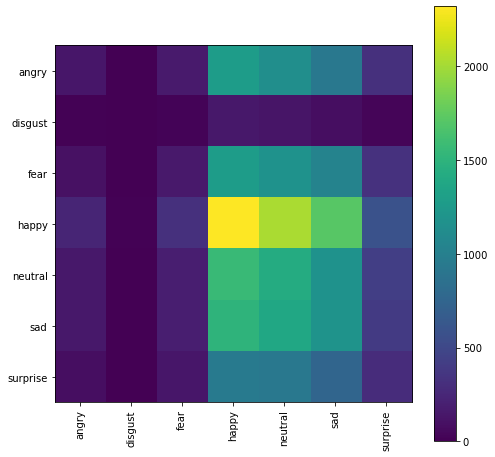

In [78]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(train_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[ 41   1  76 342 238 157 103]
 [  3   0   8  35  28  25  12]
 [ 61   5  63 345 258 199  93]
 [108   3 101 614 444 325 179]
 [ 67   8  75 405 332 215 131]
 [ 60   4  85 438 332 200 128]
 [ 40   4  29 306 222 161  69]]
Classification Report
              precision    recall  f1-score   support

       angry       0.11      0.04      0.06       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.06      0.09      1024
       happy       0.25      0.35      0.29      1774
     neutral       0.18      0.27      0.22      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.10      0.08      0.09       831

    accuracy                           0.18      7178
   macro avg       0.13      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



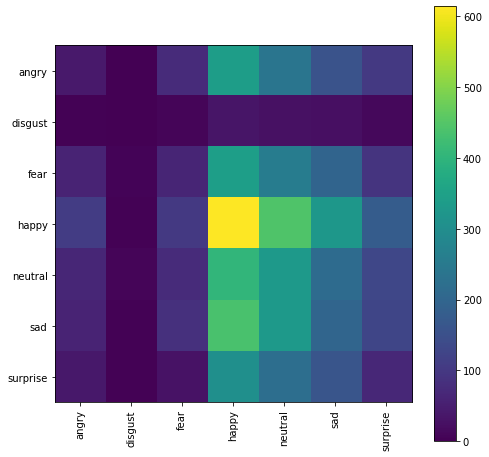

In [77]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(test_generator.classes, y_pred)

print('Confusion Matrix')
print(cm_train)

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## CNN no gen

In [22]:
allPath = []
for expression in listdir_nohidden("FER2013/train/"):
    directory = "FER2013/train/" + expression
    for pic in listdir_nohidden(directory):
        allPath.append(directory+'/'+pic)

In [23]:
allPathTest = []
for expression in listdir_nohidden("FER2013/test/"):
    directory = "FER2013/test/" + expression
    for pic in listdir_nohidden(directory):
        allPathTest.append(directory+'/'+pic)

In [24]:
allPath

['FER2013/train/happy/Training_50449107.jpg',
 'FER2013/train/happy/Training_70433018.jpg',
 'FER2013/train/happy/Training_85610005.jpg',
 'FER2013/train/happy/Training_4460748.jpg',
 'FER2013/train/happy/Training_6312930.jpg',
 'FER2013/train/happy/Training_25740534.jpg',
 'FER2013/train/happy/Training_80076077.jpg',
 'FER2013/train/happy/Training_431681.jpg',
 'FER2013/train/happy/Training_76432922.jpg',
 'FER2013/train/happy/Training_53152280.jpg',
 'FER2013/train/happy/Training_82526594.jpg',
 'FER2013/train/happy/Training_77219425.jpg',
 'FER2013/train/happy/Training_39023213.jpg',
 'FER2013/train/happy/Training_77132618.jpg',
 'FER2013/train/happy/Training_48076410.jpg',
 'FER2013/train/happy/Training_50296064.jpg',
 'FER2013/train/happy/Training_72681057.jpg',
 'FER2013/train/happy/Training_54604212.jpg',
 'FER2013/train/happy/Training_76820039.jpg',
 'FER2013/train/happy/Training_85112475.jpg',
 'FER2013/train/happy/Training_2762255.jpg',
 'FER2013/train/happy/Training_27690434

In [25]:
cv2.imread(allPath[0])

array([[[108, 108, 108],
        [ 83,  83,  83],
        [ 63,  63,  63],
        ...,
        [ 45,  45,  45],
        [ 48,  48,  48],
        [ 88,  88,  88]],

       [[115, 115, 115],
        [ 90,  90,  90],
        [ 83,  83,  83],
        ...,
        [ 34,  34,  34],
        [ 46,  46,  46],
        [ 45,  45,  45]],

       [[128, 128, 128],
        [104, 104, 104],
        [ 93,  93,  93],
        ...,
        [ 23,  23,  23],
        [ 47,  47,  47],
        [ 50,  50,  50]],

       ...,

       [[ 12,  12,  12],
        [ 30,  30,  30],
        [ 51,  51,  51],
        ...,
        [121, 121, 121],
        [118, 118, 118],
        [122, 122, 122]],

       [[  5,   5,   5],
        [ 19,  19,  19],
        [ 45,  45,  45],
        ...,
        [116, 116, 116],
        [119, 119, 119],
        [124, 124, 124]],

       [[  7,   7,   7],
        [ 10,  10,  10],
        [ 38,  38,  38],
        ...,
        [116, 116, 116],
        [122, 122, 122],
        [122, 122, 122]]

## CNN Kaggle https://www.kaggle.com/lokeswarreddy/cnn-model

In [5]:
import pathlib
from tensorflow.keras.utils import to_categorical

In [6]:
train_path = "FER2013/train" #passing the path with training images
test_path = "FER2013/test"   #passing the path with testing images

In [7]:
print("Total images available for training")
for expression in listdir_nohidden(train_path):    
    print(str(len(listdir_nohidden(train_path +'/'+ expression))) + " " + expression + " images")

Total images available for training
7215 happy images
4830 sad images
4097 fear images
3171 surprise images
4965 neutral images
3995 angry images
436 disgust images


In [8]:
print('Total images availabe for testing')
for expression in listdir_nohidden(test_path):    
    print(str(len(listdir_nohidden(test_path +'/'+ expression))) + " " + expression + " images")

Total images availabe for testing
1774 happy images
1247 sad images
1024 fear images
831 surprise images
1233 neutral images
958 angry images
111 disgust images


In [9]:
train__dir=pathlib.Path(train_path)
train__dir

PosixPath('FER2013/train')

In [10]:
image_data_dic={
    
    
    'Angry':list(train__dir.glob('angry/*')),
    'Disgust':list(train__dir.glob('disgust/*')),
    'Fear':list(train__dir.glob('fear/*')),
    'Happy':list(train__dir.glob('happy/*')),
    'Sad':list(train__dir.glob('sad/*')),
    'Surprise':list(train__dir.glob('surprise/*')),
    'Neutral':list(train__dir.glob('neutral/*')),
}

In [11]:
image_labels_dic={
    
    
    'Angry':0,
    'Disgust':1,
    'Fear':2,
    'Happy':3,
    'Sad':4,
    'Surprise':5,
    'Neutral':6,
}

In [12]:
X, y = [], []

for image_name, images in image_data_dic.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(48,48))
        X.append(resized_img)
        y.append(image_labels_dic[image_name])

In [13]:
X = np.array(X)
y=np.array(y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.15, random_state=43)

In [15]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [16]:
num_classes=7
y_train1 = to_categorical(y_train, 7)
y_test1=to_categorical(y_test,7)

In [20]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = X_test.shape[1:]))
cnn_model.add( MaxPooling2D(pool_size=2) )# down sampling the output instead of 28*28 it is 14*14
cnn_model.add( Dropout(0.2))
cnn_model.add(Flatten()) # flatten out the layers
cnn_model.add(Dense(32,activation='relu'))
cnn_model.add(Dense(7,activation = 'softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                541728    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 231       
Total params: 542,855
Trainable params: 542,855
Non-trainable params: 0
________________________________________________

In [21]:
Estop = EarlyStopping(monitor = 'val_loss',patience = 20,verbose = 1,min_delta = 0.011)
hist = cnn_model.fit(X_train_scaled, y_train1, epochs=600, steps_per_epoch=X_train_scaled.shape[0]//10, validation_data=(X_test_scaled, y_test1),callbacks=[Estop])

Epoch 1/600
2440/2440 [==============================] - 27s 11ms/step - loss: 1.7418 - accuracy: 0.2953 - val_loss: 1.5678 - val_accuracy: 0.3947
Epoch 2/600
2440/2440 [==============================] - 23s 9ms/step - loss: 1.5125 - accuracy: 0.4204 - val_loss: 1.4900 - val_accuracy: 0.4307
Epoch 3/600
2440/2440 [==============================] - 24s 10ms/step - loss: 1.4213 - accuracy: 0.4629 - val_loss: 1.5097 - val_accuracy: 0.4272
Epoch 4/600
2440/2440 [==============================] - 23s 9ms/step - loss: 1.3606 - accuracy: 0.4900 - val_loss: 1.4891 - val_accuracy: 0.4418
Epoch 5/600
2440/2440 [==============================] - 24s 10ms/step - loss: 1.3005 - accuracy: 0.5096 - val_loss: 1.5740 - val_accuracy: 0.4272
Epoch 6/600
2440/2440 [==============================] - 23s 10ms/step - loss: 1.2396 - accuracy: 0.5301 - val_loss: 1.5027 - val_accuracy: 0.4507
Epoch 7/600
2440/2440 [==============================] - 25s 10ms/step - loss: 1.1863 - accuracy: 0.5540 - val_loss: 1.5

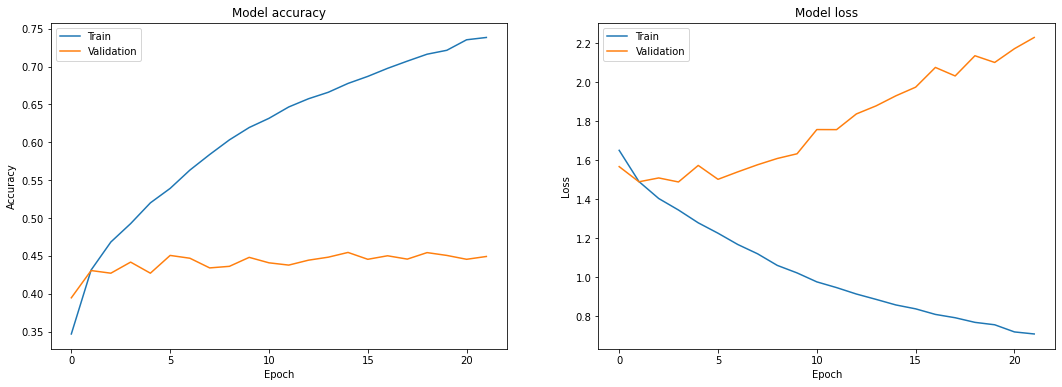

In [22]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(hist.history['accuracy'])
axes[0].plot(hist.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(hist.history['loss'])
axes[1].plot(hist.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
y_pred= cnn_model.predict(X_test_scaled)
y_test_class=np.argmax(y_test1,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.37      0.31      0.34       633
           1       0.29      0.20      0.24        79
           2       0.33      0.26      0.29       584
           3       0.61      0.61      0.61      1089
           4       0.32      0.39      0.36       681
           5       0.62      0.57      0.59       471
           6       0.40      0.47      0.43       770

    accuracy                           0.45      4307
   macro avg       0.42      0.40      0.41      4307
weighted avg       0.45      0.45      0.45      4307

[[198   9  74  90 111  23 128]
 [ 20  16   9  13   9   1  11]
 [ 69   8 152  83 127  57  88]
 [ 63   6  54 669 121  38 138]
 [ 88   9  76  83 267  21 137]
 [ 25   3  46  48  39 268  42]
 [ 73   4  43 111 148  26 365]]


In [38]:
model= Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',input_shape = X_test.shape[1:]))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

#model.add(Conv2D(64,(5,5), padding='same', activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))
    
#model.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))
    
model.add(Dense(64,activation = 'relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [39]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_26 (Batc (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 128)      

In [40]:
Estop = EarlyStopping(monitor = 'val_loss',patience = 20,verbose = 1,min_delta = 0.011)
hist = model.fit(X_train_scaled, y_train1, epochs=600, steps_per_epoch=X_train_scaled.shape[0]//10, validation_data=(X_test_scaled, y_test1),callbacks=[Estop])

Epoch 1/600
2440/2440 [==============================] - 281s 115ms/step - loss: 2.5350 - accuracy: 0.3210 - val_loss: 2.0177 - val_accuracy: 0.4021
Epoch 2/600
2440/2440 [==============================] - 272s 112ms/step - loss: 1.7757 - accuracy: 0.4660 - val_loss: 1.7153 - val_accuracy: 0.4416
Epoch 3/600
2440/2440 [==============================] - 272s 112ms/step - loss: 1.4752 - accuracy: 0.5393 - val_loss: 1.5786 - val_accuracy: 0.5038
Epoch 4/600
2440/2440 [==============================] - 274s 112ms/step - loss: 1.2363 - accuracy: 0.6115 - val_loss: 1.6466 - val_accuracy: 0.5096
Epoch 5/600
2440/2440 [==============================] - 3291s 1s/step - loss: 1.0204 - accuracy: 0.6883 - val_loss: 1.5735 - val_accuracy: 0.5338
Epoch 6/600
2440/2440 [==============================] - 4242s 2s/step - loss: 0.8126 - accuracy: 0.7673 - val_loss: 1.6575 - val_accuracy: 0.5284
Epoch 7/600
2440/2440 [==============================] - 5106s 2s/step - loss: 0.6261 - accuracy: 0.8357 - val

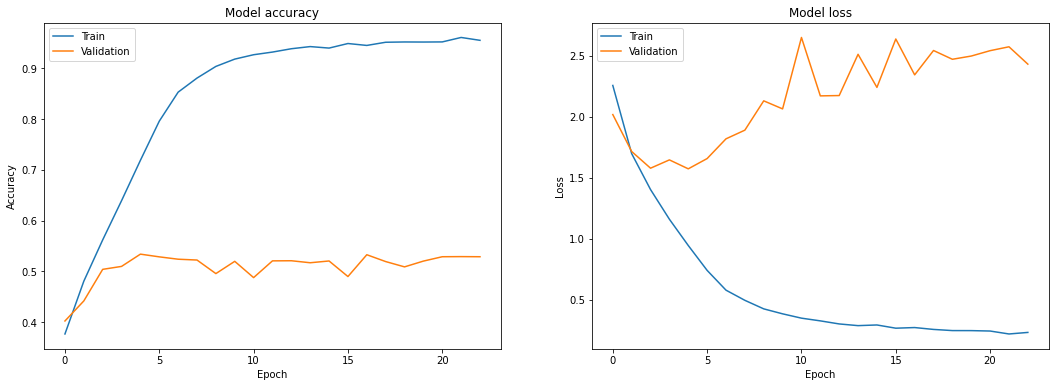

In [41]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(hist.history['accuracy'])
axes[0].plot(hist.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(hist.history['loss'])
axes[1].plot(hist.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [52]:
y_pred= model.predict(X_test_scaled)
y_test_class=np.argmax(y_test1,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       633
           1       0.01      0.15      0.02        79
           2       0.00      0.00      0.00       584
           3       0.25      0.62      0.36      1089
           4       0.20      0.06      0.09       681
           5       0.08      0.08      0.08       471
           6       0.00      0.00      0.00       770

    accuracy                           0.18      4307
   macro avg       0.08      0.13      0.08      4307
weighted avg       0.11      0.18      0.11      4307

[[  0 139   0 390  26  78   0]
 [  0  12   0  61   0   6   0]
 [  0 118   0 379  25  62   0]
 [  0 265   0 672  38 114   0]
 [  0 158   0 406  38  79   0]
 [  0 113   0 302  18  38   0]
 [  0 177   0 464  41  88   0]]


/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arnonmonkong/opt/anaconda3/envs/VisionLabEmotion/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [53]:
model= Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu',input_shape = X_test.shape[1:]))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Conv2D(64,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(256,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(BatchNormalization())
#model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten()) 
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(64,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [54]:
Estop = EarlyStopping(monitor = 'val_loss',patience = 6,verbose = 1,min_delta = 0.011)
hist = model.fit(X_train_scaled, y_train1, epochs=600, steps_per_epoch=X_train_scaled.shape[0]//10, validation_data=(X_test_scaled, y_test1),callbacks=[Estop])

Epoch 1/600
2440/2440 [==============================] - 361s 148ms/step - loss: 3.1657 - accuracy: 0.2024 - val_loss: 2.4817 - val_accuracy: 0.3476
Epoch 2/600
2440/2440 [==============================] - 342s 140ms/step - loss: 2.5340 - accuracy: 0.3139 - val_loss: 2.1502 - val_accuracy: 0.3952
Epoch 3/600
2440/2440 [==============================] - 327s 134ms/step - loss: 2.2055 - accuracy: 0.3668 - val_loss: 1.9044 - val_accuracy: 0.4391
Epoch 4/600
2440/2440 [==============================] - 261s 107ms/step - loss: 1.9385 - accuracy: 0.4029 - val_loss: 1.6384 - val_accuracy: 0.5008
Epoch 5/600
2440/2440 [==============================] - 261s 107ms/step - loss: 1.7326 - accuracy: 0.4518 - val_loss: 1.5230 - val_accuracy: 0.4999
Epoch 6/600
2440/2440 [==============================] - 257s 105ms/step - loss: 1.5872 - accuracy: 0.4819 - val_loss: 1.4016 - val_accuracy: 0.5310
Epoch 7/600
2440/2440 [==============================] - 258s 106ms/step - loss: 1.4960 - accuracy: 0.4974

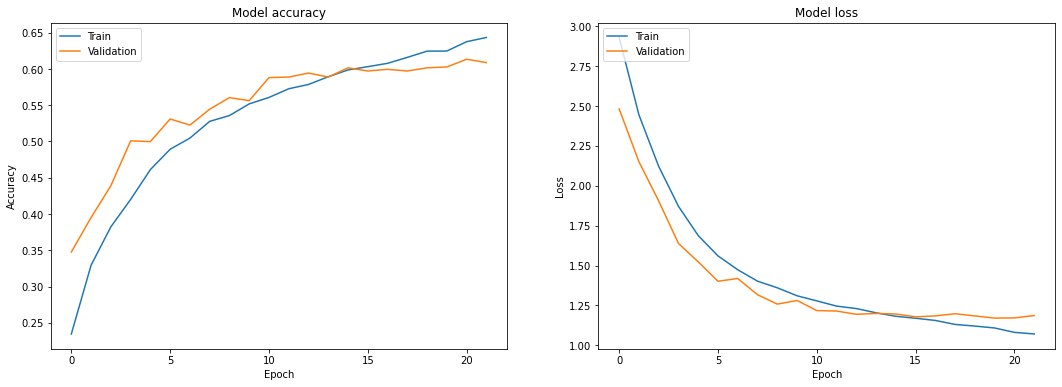

In [55]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(hist.history['accuracy'])
axes[0].plot(hist.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(hist.history['loss'])
axes[1].plot(hist.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
y_pred= model.predict(X_test_scaled)
y_test_class=np.argmax(y_test1,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.62      0.44      0.51       633
           1       0.52      0.49      0.51        79
           2       0.50      0.29      0.37       584
           3       0.78      0.84      0.81      1089
           4       0.48      0.51      0.50       681
           5       0.73      0.70      0.71       471
           6       0.50      0.70      0.58       770

    accuracy                           0.61      4307
   macro avg       0.59      0.57      0.57      4307
weighted avg       0.61      0.61      0.60      4307

[[278  16  32  52  91  26 138]
 [ 14  39   0   6  11   1   8]
 [ 50  11 171  52 118  66 116]
 [ 27   1  15 914  41  18  73]
 [ 40   4  58  53 349   4 173]
 [ 10   2  44  36  16 329  34]
 [ 29   2  24  62 103   8 542]]


In [57]:
model.save('modelCNNnoGen_optimal.h5')
model.save_weights('modelCNNnoGen_weights.h5')

In [19]:
from tensorflow import keras
model = keras.models.load_model('modelCNNnoGen_optimal.h5')

In [20]:
y_pred= model.predict(X_test_scaled)
y_test_class=np.argmax(y_test1,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.62      0.44      0.51       633
           1       0.52      0.49      0.51        79
           2       0.50      0.29      0.37       584
           3       0.78      0.84      0.81      1089
           4       0.48      0.51      0.50       681
           5       0.73      0.70      0.71       471
           6       0.50      0.70      0.58       770

    accuracy                           0.61      4307
   macro avg       0.59      0.57      0.57      4307
weighted avg       0.61      0.61      0.60      4307

[[278  16  32  52  91  26 138]
 [ 14  39   0   6  11   1   8]
 [ 50  11 171  52 118  66 116]
 [ 27   1  15 914  41  18  73]
 [ 40   4  58  53 349   4 173]
 [ 10   2  44  36  16 329  34]
 [ 29   2  24  62 103   8 542]]


## RESNET no GEN

In [38]:
base_model = ResNet50(input_shape=(48,48,3),include_top = False, weights = 'imagenet')

len(base_model.layers)

175

In [39]:
# Freezing layers 
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [40]:
# Build model on the top of base model
model = Sequential()

model.add(base_model)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(BatchNormalization())

# fully connected layer-1
model.add(Dense(128, kernel_initializer = 'he_uniform',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fully connected layer-2
model.add(Dense(64, kernel_initializer = 'he_uniform',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fully connected layer-3
model.add(Dense(32, kernel_initializer = 'he_uniform',activation='relu'))
model.add(BatchNormalization())

# output layer
model.add(Dense(7, activation = 'softmax'))

# model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [41]:
model.compile(
    optimizer = Adam(), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [42]:
Estop = EarlyStopping(monitor = 'val_loss',patience = 20,verbose = 1)
hist = model.fit(X_train_scaled, y_train1, epochs=600, steps_per_epoch=X_train_scaled.shape[0]//10, validation_data=(X_test_scaled, y_test1),callbacks=[Estop])

Epoch 1/600
2440/2440 [==============================] - 309s 126ms/step - loss: 1.9713 - accuracy: 0.2178 - val_loss: 1.7656 - val_accuracy: 0.2658
Epoch 2/600
2440/2440 [==============================] - 318s 130ms/step - loss: 1.7524 - accuracy: 0.2828 - val_loss: 1.8142 - val_accuracy: 0.2682
Epoch 3/600
2440/2440 [==============================] - 326s 133ms/step - loss: 1.7272 - accuracy: 0.2995 - val_loss: 1.8403 - val_accuracy: 0.2779
Epoch 4/600
2440/2440 [==============================] - 293s 120ms/step - loss: 1.7097 - accuracy: 0.3074 - val_loss: 1.7850 - val_accuracy: 0.2979
Epoch 5/600
2440/2440 [==============================] - 295s 121ms/step - loss: 1.6951 - accuracy: 0.3171 - val_loss: 1.6857 - val_accuracy: 0.3237
Epoch 6/600
2440/2440 [==============================] - 301s 124ms/step - loss: 1.6812 - accuracy: 0.3289 - val_loss: 1.6978 - val_accuracy: 0.3318
Epoch 7/600
2440/2440 [==============================] - 304s 124ms/step - loss: 1.6640 - accuracy: 0.3370

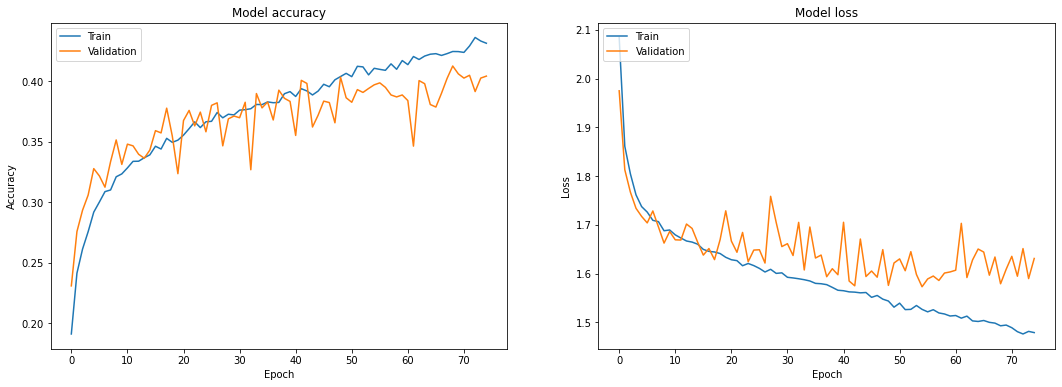

In [70]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(hist.history['accuracy'])
axes[0].plot(hist.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(hist.history['loss'])
axes[1].plot(hist.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [71]:
y_pred= model.predict(X_test_scaled)
y_test_class=np.argmax(y_test1,axis=1)
y_pred_class=np.argmax(y_pred,axis=1)
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.38      0.17      0.24       633
           1       0.16      0.05      0.08        79
           2       0.30      0.15      0.20       584
           3       0.47      0.66      0.55      1089
           4       0.35      0.22      0.27       681
           5       0.43      0.60      0.50       471
           6       0.35      0.50      0.41       770

    accuracy                           0.40      4307
   macro avg       0.35      0.34      0.32      4307
weighted avg       0.39      0.40      0.37      4307

[[108   8  41 196  64  56 160]
 [  6   4  11  29   1   6  22]
 [ 31   3  90 119  77 122 142]
 [ 50   0  41 722  58  71 147]
 [ 46   5  56 184 148  59 183]
 [ 14   2  26  69   5 282  73]
 [ 26   3  32 202  65  55 387]]


In [72]:
model.save('modelCNN_RESNET_noGen_optimal.h5')
model.save_weights('modelCNN_RESNET_noGen_weights.h5')